In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

In [3]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [4]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

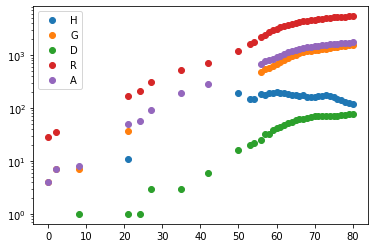

In [5]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

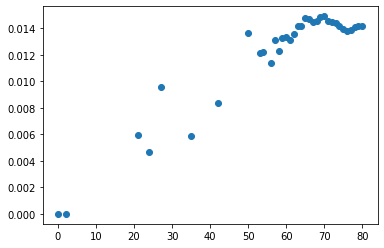

In [6]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [7]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 77*2,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

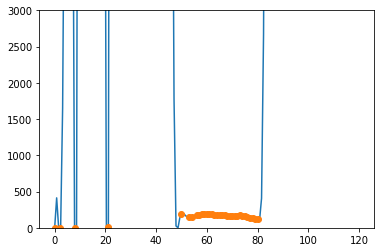

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [13]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  40  1.0650454e+02 0.00e+00 5.13e-04  -8.6 1.71e+02  -8.8 1.00e+00 3.72e-02f  1
  50  1.0650027e+02 0.00e+00 7.19e-01  -8.6 1.69e+03 -12.6 1.00e+00 3.23e-02h  1
  60  1.0649673e+02 0.00e+00 3.02e-01  -8.6 1.23e+03 -12.0 1.00e+00 1.00e+00f  1
  70  1.0648086e+02 0.00e+00 3.47e-01  -8.6 1.01e+03 -12.2 1.19e-01 1.00e+00f  1
  80  1.0648029e+02 0.00e+00 8.47e-04  -8.6 2.13e+01  -9.8 1.00e+00 1.00e+00h  1
  90  1.0647940e+02 0.00e+00 2.84e-01  -8.6 2.98e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0647556e+02 0.00e+00 3.87e-01  -8.6 5.59e+01  -9.4 1.00e+00 1.00e+00f  1
 110  1.0647408e+02 0.00e+00 7.58e-02  -8.6 2.84e+04 -13.7 1.04e-01 6.79e-01f  1
 120  1.0647386e+02 0.00e+00 3.62e-02  -8.6 2.39e+00  -9.9 1.00e+00 1.00e+00h  1
 130  1.0647384e+02 0.00e+00 1.77e-02  -8.6 1.05e+00  -5.1 1.00e+00 1.00e+00f  1
 140  1.0647383e+02 0.00e+00 3.39e-03  -8.6 2.84e+02    -  1.00e+00 1.00e+00h  1
 150  1.0647383e+02 0.00e+00

  40  1.0736681e+02 0.00e+00 3.78e-03  -8.6 1.06e+01  -6.9 1.00e+00 2.16e-01f  1
  50  1.0736548e+02 0.00e+00 2.30e-03  -8.6 3.89e+02 -11.6 1.00e+00 1.00e+00h  1
  60  1.0736436e+02 0.00e+00 6.58e-01  -8.6 2.42e+04 -13.7 1.05e-01 1.76e-02h  1
  70  1.0736127e+02 0.00e+00 4.00e-01  -8.6 1.25e+03 -12.1 1.00e+00 1.00e+00f  1
  80  1.0734724e+02 0.00e+00 4.64e-01  -8.6 3.82e+02 -11.5 2.84e-01 1.00e+00f  1
  90  1.0734589e+02 0.00e+00 1.03e-02  -8.6 2.44e+03 -12.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0734564e+02 0.00e+00 2.13e-02  -8.6 4.29e+02 -12.0 1.00e+00 1.00e+00h  1
 110  1.0734527e+02 0.00e+00 5.71e-03  -8.6 3.74e+02 -12.3 1.00e+00 1.00e+00h  1
 120  1.0734504e+02 0.00e+00 1.01e-01  -8.6 2.62e+03 -13.4 1.00e+00 1.00e+00h  1
 130  1.0734483e+02 0.00e+00 5.24e-04  -8.6 9.00e+02 -13.7 1.00e+00 1.00e+00f  1
 140  1.0734467e+02 0.00e+00 1.67e-01  -8.6 1.21e+04 -13.9 5.90e-02 1.95e-03h 10
 150  1.0734455e+02 0.00e+00

 290  1.0791609e+02 0.00e+00 4.19e-02  -8.6 6.19e+01 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.0791604e+02 0.00e+00 2.44e-01  -8.6 1.18e+03 -14.0 1.00e+00 5.00e-01h  2
 310  1.0791601e+02 0.00e+00 1.55e-02  -8.6 2.82e+02 -11.6 5.93e-01 1.00e+00f  1
 320  1.0791599e+02 0.00e+00 3.90e-02  -8.6 6.39e+02 -10.9 1.00e+00 5.00e-01f  2
 330  1.0791598e+02 0.00e+00 6.58e-02  -8.6 3.22e+04    -  6.76e-01 7.82e-02h  2
 340  1.0791598e+02 0.00e+00 7.18e-02  -8.6 6.15e+02 -15.4 1.00e+00 5.00e-01h  2
 350  1.0791598e+02 0.00e+00 4.38e-04  -8.6 1.65e+01 -11.9 1.00e+00 1.00e+00h  1
 360  1.0791597e+02 0.00e+00 3.35e-03  -8.6 4.53e+02 -15.2 1.00e+00 1.00e+00h  1
 370  1.0791597e+02 0.00e+00 5.66e-03  -8.6 3.58e+00 -10.1 1.00e+00 1.00e+00h  1
 380  1.0791597e+02 0.00e+00 6.62e-02  -8.6 3.27e+02 -14.8 1.00e+00 1.00e+00h  1
 390  1.0791596e+02 0.00e+00 1.02e-01  -8.6 3.98e+02 -13.3 8.31e-01 1.00e+00h  1
iter    objective    inf_pr 

  40  1.0931336e+02 0.00e+00 2.33e+00  -5.7 1.51e+03 -11.8 1.00e+00 2.50e-01f  3
  50  1.0931186e+02 0.00e+00 6.11e-01  -5.7 1.01e+04 -12.5 1.00e+00 2.09e-01f  3
  60  1.0931124e+02 0.00e+00 3.67e-01  -5.7 1.07e+03 -11.8 1.00e+00 1.00e+00f  1
  70  1.0931082e+02 0.00e+00 7.25e-01  -5.7 3.18e+04    -  9.03e-01 7.95e-02f  3
  80  1.0931053e+02 0.00e+00 8.00e-01  -5.7 4.50e+04    -  3.20e-01 2.84e-02f  3
  90  1.0931014e+02 0.00e+00 7.74e-01  -5.7 3.51e+03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0930983e+02 0.00e+00 3.70e-01  -5.7 4.55e+02 -13.4 1.00e+00 1.00e+00h  1
 110  1.0930954e+02 0.00e+00 3.34e-02  -5.7 7.68e+01 -10.5 1.00e+00 1.00e+00h  1
 120  1.0930942e+02 0.00e+00 4.44e-02  -5.7 4.69e+02 -12.8 1.00e+00 1.00e+00h  1
 130  1.0930935e+02 0.00e+00 5.12e-02  -5.7 1.38e+03    -  1.00e+00 1.00e+00h  1
 140  1.0930920e+02 0.00e+00 1.28e-01  -8.6 1.19e+02 -11.2 1.00e+00 6.64e-01f  1
 150  1.0930913e+02 0.00e+00

  50  1.1096133e+02 0.00e+00 3.13e-01  -5.7 3.02e+02 -11.1 1.00e+00 1.00e+00f  1
  60  1.1095947e+02 0.00e+00 1.70e+00  -5.7 3.02e+03 -12.3 1.00e+00 1.00e+00f  1
  70  1.1095858e+02 0.00e+00 6.48e-01  -5.7 4.35e+02 -11.7 1.00e+00 1.00e+00f  1
  80  1.1095782e+02 0.00e+00 8.05e-01  -5.7 3.42e+02 -11.4 1.00e+00 1.00e+00h  1
  90  1.1095704e+02 0.00e+00 4.73e-01  -5.7 1.58e+03 -13.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1095659e+02 0.00e+00 4.22e-01  -5.7 4.23e+02  -9.7 1.00e+00 1.25e-01f  4
 110  1.1095625e+02 0.00e+00 6.43e-02  -5.7 1.31e+02 -11.2 1.00e+00 1.00e+00h  1
 120  1.1095608e+02 0.00e+00 6.01e-01  -5.7 5.65e+03    -  1.00e+00 5.00e-01h  2
 130  1.1095600e+02 0.00e+00 1.85e-03  -5.7 3.60e+01 -12.8 1.00e+00 1.00e+00h  1
 140  1.1095584e+02 0.00e+00 8.99e-02  -8.6 1.38e+02 -11.6 1.00e+00 1.00e+00h  1
 150  1.1095581e+02 0.00e+00 1.03e-01  -8.6 1.65e+04    -  1.00e+00 1.25e-01f  4
 160  1.1095580e+02 0.00e+00

  60  1.1271915e+02 0.00e+00 6.05e+00  -3.8 2.90e+03    -  1.00e+00 5.00e-01f  2
  70  1.1272301e+02 0.00e+00 8.76e+00  -3.8 3.71e+03    -  1.00e+00 2.50e-01f  3
  80  1.1272223e+02 0.00e+00 1.17e+00  -3.8 1.24e+03 -12.4 1.00e+00 1.00e+00f  1
  90  1.1272309e+02 0.00e+00 3.16e+00  -3.8 4.59e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1272410e+02 0.00e+00 3.44e+00  -3.8 2.05e+03    -  1.00e+00 1.00e+00f  1
 110  1.1271300e+02 0.00e+00 3.06e+00  -5.7 1.00e+04    -  8.07e-01 7.15e-01f  1
 120  1.1270733e+02 0.00e+00 2.99e-02  -5.7 1.93e+02 -12.8 1.00e+00 1.00e+00h  1
 130  1.1270726e+02 0.00e+00 1.35e-02  -5.7 1.68e+02 -12.5 1.00e+00 1.00e+00f  1
 140  1.1270721e+02 0.00e+00 7.74e-03  -5.7 7.99e+01 -13.2 1.00e+00 1.00e+00h  1
 150  1.1270716e+02 0.00e+00 1.38e+00  -5.7 1.78e+03 -13.4 1.00e+00 5.00e-01h  2
 160  1.1270702e+02 0.00e+00 6.93e-01  -5.7 2.87e+04    -  3.22e-01 2.40e-02f  6
 170  1.1270683e+02 0.00e+00


Number of Iterations....: 329

                                   (scaled)                 (unscaled)
Objective...............:   1.1351922600351183e+02    1.1351922600351183e+02
Dual infeasibility......:   1.4077575605610845e-13    1.4077575605610845e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 597
Number of objective gradient evaluations             = 330
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 597
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 330
Number of Lagrangian Hessian evaluations             = 329
Total CPU secs in IPOPT (w/o function evaluations)   =      2.252
Total CPU secs in NLP function eval

  20  1.3281879e+02 0.00e+00 5.82e+00  -1.0 6.04e+02  -6.4 1.00e+00 1.00e+00f  1
  30  1.3598355e+02 0.00e+00 1.99e+02  -1.0 1.04e+04  -9.2 6.79e-01 5.00e-01f  2
  40  1.1940939e+02 0.00e+00 9.03e-01  -1.7 5.81e+02    -  1.00e+00 1.00e+00f  1
  50  1.1585057e+02 0.00e+00 2.61e-01  -3.8 1.10e+03 -11.2 1.00e+00 1.00e+00f  1
  60  1.1584949e+02 0.00e+00 4.70e-01  -3.8 4.55e+02    -  1.00e+00 1.00e+00h  1
  70  1.1583555e+02 0.00e+00 3.98e+00  -5.7 1.33e+04    -  1.00e+00 2.54e-01h  2
  80  1.1583588e+02 0.00e+00 7.64e+00  -5.7 1.96e+03    -  1.00e+00 1.00e+00h  1
  90  1.1583541e+02 0.00e+00 6.02e-02  -5.7 1.33e+02 -12.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1583537e+02 0.00e+00 4.37e-01  -5.7 1.25e+03    -  1.00e+00 2.50e-01h  3
 110  1.1583533e+02 0.00e+00 6.35e-01  -5.7 3.34e+04    -  4.82e-01 1.07e-02h  7
 120  1.1583527e+02 0.00e+00 3.35e-01  -5.7 2.15e+02 -13.8 1.00e+00 1.00e+00h  1
 130  1.1583522e+02 0.00e+00

  30  1.3942969e+02 0.00e+00 5.93e+02  -1.0 3.68e+04    -  4.24e-01 2.25e-01f  2
  40  1.2030649e+02 0.00e+00 5.54e+00  -2.5 3.36e+03    -  9.22e-01 9.14e-01f  1
  50  1.1778273e+02 0.00e+00 5.81e+01  -3.8 2.33e+04    -  9.40e-01 4.47e-01f  1
  60  1.1775139e+02 0.00e+00 3.42e+00  -5.7 2.43e+03    -  9.95e-01 8.93e-01f  1
  70  1.1775036e+02 0.00e+00 5.83e-03  -5.7 8.13e+01 -12.2 1.00e+00 1.00e+00f  1
  80  1.1775593e+02 0.00e+00 3.57e+01  -5.7 7.04e+03    -  1.00e+00 5.00e-01h  2
  90  1.1775027e+02 0.00e+00 1.44e-01  -5.7 1.77e+02 -13.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1775024e+02 0.00e+00 2.15e-02  -5.7 5.63e+01 -12.7 1.00e+00 1.00e+00h  1
 110  1.1775163e+02 0.00e+00 1.92e+01  -5.7 3.13e+03    -  1.00e+00 5.00e-01h  2
 120  1.1774999e+02 0.00e+00 9.76e-04  -5.7 1.75e+01 -11.7 1.00e+00 1.00e+00f  1
 130  1.1774990e+02 0.00e+00 1.89e+00  -5.7 1.36e+04    -  1.00e+00 1.25e-01h  4
 140  1.1774971e+02 0.00e+00

  30  1.3953557e+02 0.00e+00 4.34e+01  -1.0 1.59e+03  -8.3 1.00e+00 1.00e+00f  1
  40  1.2411507e+02 0.00e+00 4.60e+00  -1.7 2.13e+03    -  1.00e+00 1.00e+00f  1
  50  1.2031371e+02 0.00e+00 1.67e+01  -3.8 7.56e+03 -11.2 1.00e+00 9.79e-01f  1
  60  1.2029801e+02 0.00e+00 7.40e+00  -5.7 2.52e+04    -  1.00e+00 1.24e-01f  3
  70  1.2029781e+02 0.00e+00 5.48e-01  -5.7 1.55e+04    -  1.00e+00 3.12e-02h  6
  80  1.2029773e+02 0.00e+00 5.03e-02  -5.7 1.00e+02 -13.0 1.00e+00 1.00e+00h  1
  90  1.2029765e+02 0.00e+00 2.96e+00  -5.7 1.37e+03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2029757e+02 0.00e+00 2.59e-01  -5.7 1.59e+02 -12.9 1.00e+00 1.00e+00h  1
 110  1.2029749e+02 0.00e+00 5.25e+00  -5.7 5.32e+03 -13.1 1.00e+00 3.62e-01h  2
 120  1.2029737e+02 0.00e+00 3.53e-02  -5.7 4.00e+01 -12.0 1.00e+00 1.00e+00f  1
 130  1.2029720e+02 0.00e+00 2.86e-01  -5.7 1.02e+02 -12.6 1.00e+00 1.00e+00h  1
 140  1.2029696e+02 0.00e+00

  30  1.2261811e+02 0.00e+00 6.35e-01  -3.8 1.20e+02  -9.4 1.00e+00 1.00e+00f  1
  40  1.2255436e+02 0.00e+00 1.86e+00  -3.8 1.29e+04    -  1.00e+00 1.00e+00f  1
  50  1.2252337e+02 0.00e+00 4.36e-01  -5.7 2.34e+02 -10.1 8.53e-01 6.68e-01f  1
  60  1.2251895e+02 0.00e+00 6.65e-02  -5.7 6.16e+03    -  1.00e+00 1.00e+00h  1
  70  1.2251875e+02 0.00e+00 7.37e-02  -8.6 5.51e+03 -14.4 9.23e-01 9.70e-01f  1

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   1.2251871177481947e+02    1.2251871177481947e+02
Dual infeasibility......:   3.8589576141222707e-10    3.8589576141222707e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6517463428141118e-09    2.6517463428141118e-09
Overall NLP error.......:   2.6517463428141118e-09    2.6517463428141118e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations       

 270  1.2492962e+02 0.00e+00 3.18e-01  -5.7 2.53e+02 -10.2 1.00e+00 9.62e-01f  1
 280  1.2492076e+02 0.00e+00 1.33e+00  -5.7 4.88e+03    -  1.00e+00 5.00e-01f  2
 290  1.2491673e+02 0.00e+00 2.60e-01  -5.7 1.35e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2491586e+02 0.00e+00 2.21e-01  -8.6 2.99e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 306

                                   (scaled)                 (unscaled)
Objective...............:   1.2491580006446138e+02    1.2491580006446138e+02
Dual infeasibility......:   1.5475174764644270e-10    1.5475174764644270e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088047124230866e-09    2.5088047124230866e-09
Overall NLP error.......:   2.5088047124230866e-09    2.5088047124230866e-09


Number of objective function evaluations             = 455
Number of objective gradient evaluations      

 240  1.2760789e+02 0.00e+00 6.14e+00  -5.7 4.36e+02  -7.6 5.95e-02 3.42e-02f  1
 250  1.2755206e+02 0.00e+00 3.72e+00  -5.7 6.25e+02 -10.6 5.81e-01 8.62e-01f  1
 260  1.2753673e+02 0.00e+00 9.14e-01  -5.7 7.08e+01  -8.0 2.38e-02 1.64e-02f  1
 270  1.2753246e+02 0.00e+00 9.90e-01  -5.7 1.50e+04    -  1.00e+00 1.00e+00f  1
 280  1.2753119e+02 0.00e+00 1.18e-01  -8.6 3.09e+04    -  7.43e-01 1.66e-01f  1

Number of Iterations....: 286

                                   (scaled)                 (unscaled)
Objective...............:   1.2753116602377902e+02    1.2753116602377902e+02
Dual infeasibility......:   1.2702415543752668e-10    1.2702415543752668e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5322105414796770e-09    2.5322105414796770e-09
Overall NLP error.......:   2.5322105414796770e-09    2.5322105414796770e-09


Number of objective function evaluations             = 428
Number of objective gradient evaluations      

  60  1.3736128e+02 0.00e+00 2.52e+02  -1.7 3.74e+03 -11.4 1.00e+00 1.00e+00f  1
  70  1.3445762e+02 0.00e+00 1.64e+00  -3.8 2.60e+02 -11.0 1.00e+00 1.00e+00f  1
  80  1.3445051e+02 0.00e+00 5.31e+00  -3.8 6.00e+02 -12.1 1.00e+00 1.00e+00f  1
  90  1.3444951e+02 0.00e+00 3.56e-02  -3.8 3.57e+01 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3444922e+02 0.00e+00 5.80e-03  -3.8 1.58e+01 -12.8 1.00e+00 1.00e+00h  1
 110  1.3444901e+02 0.00e+00 3.97e-01  -3.8 9.21e+01    -  1.00e+00 1.00e+00h  1
 120  1.3444886e+02 0.00e+00 1.89e-01  -3.8 1.10e+02    -  1.00e+00 5.00e-01h  2
 130  1.3444871e+02 0.00e+00 2.93e-01  -3.8 7.58e+01    -  1.00e+00 1.00e+00h  1
 140  1.3444857e+02 0.00e+00 2.50e-01  -3.8 5.24e+02    -  1.00e+00 1.25e-01h  4
 150  1.3444823e+02 0.00e+00 9.20e-01  -3.8 4.88e+02    -  1.00e+00 2.50e-01h  3
 160  1.3444786e+02 0.00e+00 4.02e+00  -3.8 4.99e+02    -  1.00e+00 5.00e-01h  2
 170  1.3444737e+02 0.00e+00

  20  1.3772312e+02 0.00e+00 1.96e+01  -3.8 2.60e+02  -7.3 1.00e+00 5.49e-01f  1
  30  1.3576466e+02 0.00e+00 1.22e+01  -3.8 2.10e+04    -  3.41e-01 9.86e-01f  1
  40  1.3566666e+02 0.00e+00 5.43e-01  -3.8 2.44e+02    -  1.00e+00 1.00e+00f  1
  50  1.3565250e+02 0.00e+00 5.85e-02  -8.6 7.24e+03    -  8.27e-01 6.83e-01f  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   1.3565249385115192e+02    1.3565249385115192e+02
Dual infeasibility......:   3.8185928550487029e-10    3.8185928550487029e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6443417512980173e-09    2.6443417512980173e-09
Overall NLP error.......:   2.6443417512980173e-09    2.6443417512980173e-09


Number of objective function evaluations             = 71
Number of objective gradient evaluations             = 56
Number of equality constraint evaluations            = 0
Number of ineq

  20  1.4603974e+02 0.00e+00 1.68e+02  -2.5 3.52e+03    -  5.73e-01 1.00e+00f  1
  30  1.4547943e+02 0.00e+00 4.03e-01  -2.5 1.53e+01  -7.0 1.00e+00 1.00e+00f  1
  40  1.4499101e+02 0.00e+00 3.69e-05  -3.8 1.18e+01    -  1.00e+00 1.00e+00h  1
  50  1.4497802e+02 0.00e+00 1.86e-09  -5.7 6.61e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   1.4497775316055694e+02    1.4497775316055694e+02
Dual infeasibility......:   9.2555181718766522e-09    9.2555181718766522e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2607889837153561e-09    1.2607889837153561e-09
Overall NLP error.......:   9.2555181718766522e-09    9.2555181718766522e-09


Number of objective function evaluations             = 72
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of ineq

  30  1.5727921e+02 0.00e+00 1.28e-04  -3.8 2.85e+01    -  1.00e+00 1.00e+00h  1
  40  1.5726652e+02 0.00e+00 2.38e-03  -8.6 2.67e+03    -  8.92e-01 6.88e-01f  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   1.5726650814544851e+02    1.5726650814544851e+02
Dual infeasibility......:   5.3396322658617106e-09    5.3396322658617106e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3783922794867529e-09    1.3783922794867529e-09
Overall NLP error.......:   5.3396322658617106e-09    5.3396322658617106e-09


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 51
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 46
Num

    nlp_grad  | 161.00us (161.00us) 160.23us (160.23us)         1
  nlp_grad_f  |   5.62ms (144.18us)   5.63ms (144.34us)        39
  nlp_hess_l  |  39.12ms (  1.06ms)  39.20ms (  1.06ms)        37
   nlp_jac_g  |   1.76ms ( 45.18us)   1.77ms ( 45.37us)        39
       total  | 227.64ms (227.64ms) 226.70ms (226.70ms)         1
Solving for p=0.05336699231206313
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints........

  50  1.9488487e+02 0.00e+00 4.48e+01  -2.5 4.45e+04    -  7.25e-01 1.25e-01f  4
  60  1.9439647e+02 0.00e+00 3.60e-01  -3.8 8.35e+00  -8.3 1.00e+00 9.69e-01f  1
  70  1.9437847e+02 0.00e+00 5.07e-02  -5.7 5.87e+03    -  1.00e+00 2.67e-01f  2

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   1.9437813876970603e+02    1.9437813876970603e+02
Dual infeasibility......:   5.0987162150257461e-11    5.0987162150257461e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5535150443302565e-09    2.5535150443302565e-09
Overall NLP error.......:   2.5535150443302565e-09    2.5535150443302565e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 121
Number of equality constraint Jacob

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   3.4392812674407804e+02    3.4392812674407804e+02
Dual infeasibility......:   1.6750849177946492e-11    1.6750849177946492e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8572372473400009e-09    2.8572372473400009e-09
Overall NLP error.......:   2.8572372473400009e-09    2.8572372473400009e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39
Number of Lagrangian Hessian evaluations             = 38
Total CPU secs in IPOPT (w/o function evaluations)   =      0.178
Total CPU secs in NLP function evaluation

  30  5.6057652e+02 0.00e+00 2.92e-06  -3.8 1.47e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.6055850704465752e+02    5.6055850704465752e+02
Dual infeasibility......:   6.6713458868598258e-11    6.6713458868598258e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5120234976595405e-09    2.5120234976595405e-09
Overall NLP error.......:   2.5120234976595405e-09    2.5120234976595405e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 47
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w


Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   8.3548137095562140e+02    8.3548137095562140e+02
Dual infeasibility......:   2.2453859469473538e-11    2.2453859469473538e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5664064539471563e-09    2.5664064539471563e-09
Overall NLP error.......:   2.5664064539471563e-09    2.5664064539471563e-09


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w/o function evaluations)   =      0.179
Total CPU secs in NLP function evaluation

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4051944e+03 0.00e+00 5.30e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.3938697e+03 0.00e+00 2.27e+03  -1.7 9.75e+02    -  9.51e-01 1.00e+00f  1
  20  1.3878298e+03 0.00e+00 7.37e+00  -5.7 2.96e+04    -  7.40e-01 4.96e-01f  1

Number of Iterations....: 27

                                   (scaled)                 (unscale

Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w/o function evaluations)   =      0.191
Total CPU secs in NLP function evaluations           =      0.052

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.93ms ( 71.46us)   2.94ms ( 71.63us)        41
       nlp_g  |   1.43ms ( 34.78us)   1.42ms ( 34.59us)        41
    nlp_grad  | 160.00us (160.00us) 159.59us (159.59us)         1
  nlp_grad_f  |   5.60ms (143.62us)   5.62ms (143.99us)        39
  nlp_hess_l  |  39.43ms (  1.07ms)  39.50ms (  1.07ms)        37
   nlp_jac_g  |   1.85ms ( 47.36us)   1.84ms ( 47.10us)        39
       total  | 243.81ms (243.81ms) 242.81ms (242.81ms)         1
Solving for p=43.287612810830616
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzero

  10  2.9343839e+03 0.00e+00 4.21e+01  -1.7 1.84e+03    -  7.66e-01 1.00e+00f  1
  20  2.9334483e+03 0.00e+00 2.01e+02  -3.8 1.80e+04    -  1.00e+00 1.00e+00f  1
  30  2.9333579e+03 0.00e+00 1.86e-02  -5.7 9.16e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   2.9333578397760853e+03    2.9333578397760853e+03
Dual infeasibility......:   5.5338670738773856e-09    5.5338670738773856e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.4113016762803068e-09    7.4113016762803068e-09
Overall NLP error.......:   7.4113016762803068e-09    7.4113016762803068e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobia

  40  3.6305405e+03 0.00e+00 5.73e-04  -5.7 1.31e+01  -9.1 1.00e+00 1.00e+00h  1
  50  3.6305073e+03 0.00e+00 3.63e+01  -5.7 3.89e+03 -11.2 1.00e+00 5.00e-01f  2
  60  3.6304645e+03 0.00e+00 7.29e+01  -5.7 1.48e+03 -10.5 1.00e+00 1.00e+00f  1
  70  3.6304033e+03 0.00e+00 1.35e+02  -5.7 7.78e+03 -10.8 1.00e+00 2.50e-01f  3
  80  3.6302006e+03 0.00e+00 1.54e+02  -5.7 2.54e+03 -10.1 1.00e+00 1.00e+00f  1
  90  3.6299893e+03 0.00e+00 2.23e+02  -5.7 2.73e+03  -9.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6296885e+03 0.00e+00 4.16e-04  -5.7 6.32e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 104

                                   (scaled)                 (unscaled)
Objective...............:   3.4590123119133650e+03    3.6296885030384483e+03
Dual infeasibility......:   7.3680074951526886e-10    7.7315631411162929e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  50  4.3752278e+03 0.00e+00 9.05e+01  -5.7 2.74e+03 -10.5 1.00e+00 1.00e+00f  1
  60  4.3750908e+03 0.00e+00 1.99e+01  -5.7 1.23e+02  -8.9 1.00e+00 1.00e+00f  1
  70  4.3749517e+03 0.00e+00 1.39e+02  -5.7 3.31e+01  -7.4 1.00e+00 1.00e+00f  1
  80  4.3747227e+03 0.00e+00 2.54e+01  -5.7 9.05e+02  -9.4 1.00e+00 1.00e+00f  1
  90  4.3744178e+03 0.00e+00 1.82e+02  -5.7 2.00e+01  -6.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3743164e+03 0.00e+00 1.22e-09  -5.7 1.14e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:   3.7710123951414616e+03    4.3743163747144899e+03
Dual infeasibility......:   7.6562177353249589e-09    8.8810948092243351e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5322132013444229e-09    2.9373283644413982e-09
Overall NLP error.....

  10  5.0632022e+03 0.00e+00 3.69e+03  -1.0 3.55e+03    -  6.16e-01 3.12e-02f  6
  20  5.0607834e+03 0.00e+00 1.10e+03  -1.0 1.01e+03    -  6.66e-01 1.25e-01f  4
  30  5.0601804e+03 0.00e+00 3.66e+00  -1.0 9.45e-02  -2.9 1.00e+00 1.00e+00f  1
  40  5.0646823e+03 0.00e+00 5.24e+03  -1.0 1.24e+04    -  1.00e+00 5.00e-01f  2
  50  5.0554904e+03 0.00e+00 3.52e+02  -1.7 3.87e+03    -  1.00e+00 5.00e-01f  2
  60  5.0544301e+03 0.00e+00 4.33e+01  -3.8 1.23e+04    -  1.00e+00 1.00e+00F  1
  70  5.0543962e+03 0.00e+00 1.99e+02  -5.7 6.16e+04    -  1.00e+00 1.38e-01f  2
  80  5.0543800e+03 0.00e+00 6.43e-05  -5.7 5.97e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 86

                                   (scaled)                 (unscaled)
Objective...............:   4.4781151590302161e+03    5.0543799069756260e+03
Dual infeasibility......:   4.2926541865517280e-09    4.8450529514297950e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

 120  5.2853607e+03 0.00e+00 5.33e+03  -1.7 5.37e+03    -  1.00e+00 1.56e-02f  7
 130  5.2839028e+03 0.00e+00 6.94e+02  -1.7 9.21e+00  -5.1 1.00e+00 1.00e+00f  1
 140  5.2821244e+03 0.00e+00 4.24e+01  -1.7 2.11e+00  -4.4 1.00e+00 1.00e+00f  1
 150  5.2801446e+03 0.00e+00 9.68e+03  -1.7 2.64e+01  -5.5 1.00e+00 1.00e+00f  1
 160  5.2761539e+03 0.00e+00 9.48e+02  -1.7 1.47e+00  -3.9 1.00e+00 1.00e+00f  1
 170  5.2734868e+03 0.00e+00 9.60e+01  -1.7 2.28e-01  -2.8 1.00e+00 1.00e+00f  1
 180  5.2721906e+03 0.00e+00 7.26e+01  -1.7 5.21e-01  -3.5 1.00e+00 1.00e+00f  1
 190  5.2681320e+03 0.00e+00 1.59e+03  -1.7 6.70e+00  -4.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.2653766e+03 0.00e+00 1.82e+03  -1.7 2.51e+00  -3.9 1.00e+00 2.50e-01f  3
 210  5.2593974e+03 0.00e+00 7.68e+03  -1.7 6.08e+01  -5.5 1.00e+00 5.00e-01f  2
 220  5.2518489e+03 0.00e+00 4.64e+01  -1.7 2.64e-01  -2.0 1.00e+00 1.00e+00f  1
 230  5.2489218e+03 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0661947e+03 0.00e+00 4.40e+01  -1.0 0.00e+00    -  0.00e+00 0.

  20  5.1275569e+03 0.00e+00 1.33e+01  -1.7 1.42e-01  -3.1 1.00e+00 1.00e+00f  1
  30  5.1278470e+03 0.00e+00 1.31e+04  -1.7 5.18e+03    -  8.73e-01 1.25e-01f  4
  40  5.1279395e+03 0.00e+00 1.13e+04  -1.7 8.87e+03    -  9.68e-01 1.25e-01f  4
  50  5.1277693e+03 0.00e+00 1.46e+03  -2.5 1.68e+04    -  8.46e-01 3.12e-02f  6
  60  5.1277508e+03 0.00e+00 3.29e+00  -3.8 1.72e-01  -5.0 1.00e+00 1.00e+00f  1
  70  5.1277469e+03 0.00e+00 2.09e+02  -3.8 2.68e+02  -9.8 1.00e+00 1.00e+00f  1
  80  5.1277417e+03 0.00e+00 8.95e+01  -3.8 1.34e+01  -8.2 1.00e+00 1.00e+00f  1
  90  5.1277364e+03 0.00e+00 4.56e+02  -3.8 1.54e+02  -9.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1277307e+03 0.00e+00 4.56e+02  -3.8 8.77e+00  -7.8 1.00e+00 1.00e+00f  1
 110  5.1277252e+03 0.00e+00 5.56e+01  -3.8 2.70e+01  -8.1 1.00e+00 5.00e-01f  2
 120  5.1277221e+03 0.00e+00 8.23e-01  -3.8 1.26e+01  -8.3 1.00e+00 1.00e+00f  1
 130  5.1277104e+03 0.00e+00

 190  5.1612081e+03 0.00e+00 1.33e+02  -5.7 1.14e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.1612058e+03 0.00e+00 1.02e+02  -5.7 1.53e+03 -10.2 1.00e+00 6.25e-02f  5
 210  5.1612034e+03 0.00e+00 1.14e+02  -5.7 1.49e+03  -9.6 1.00e+00 6.25e-02f  5
 220  5.1612010e+03 0.00e+00 4.11e+01  -5.7 9.51e+01  -9.8 1.00e+00 1.00e+00f  1
 230  5.1611989e+03 0.00e+00 5.57e+00  -5.7 2.23e+01  -9.2 1.00e+00 1.00e+00f  1
 240  5.1611954e+03 0.00e+00 3.88e+02  -5.7 7.49e+01  -9.4 1.00e+00 1.00e+00f  1
 250  5.1611930e+03 0.00e+00 3.09e+02  -5.7 7.48e+02  -9.7 1.00e+00 1.25e-01f  4
 260  5.1611906e+03 0.00e+00 3.32e+02  -5.7 3.72e+00  -9.1 1.00e+00 1.00e+00f  1
 270  5.1611875e+03 0.00e+00 5.86e+02  -5.7 2.97e+02 -10.2 1.00e+00 1.00e+00f  1
 280  5.1611853e+03 0.00e+00 1.29e+00  -5.7 8.59e+00  -8.7 1.00e+00 1.00e+00h  1
 290  5.1611818e+03 0.00e+00 2.98e+00  -5.7 1.32e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  10  5.1975796e+03 0.00e+00 1.71e+03  -1.0 3.35e+00  -3.6 1.00e+00 1.00e+00f  1
  20  5.1952851e+03 0.00e+00 5.39e+02  -2.5 4.73e-01  -3.3 1.00e+00 1.00e+00f  1
  30  5.1953341e+03 0.00e+00 6.21e+03  -2.5 1.18e+03    -  8.62e-01 1.25e-01f  4
  40  5.1953343e+03 0.00e+00 5.62e+01  -2.5 1.01e-01  -4.5 1.00e+00 1.00e+00f  1
  50  5.1953869e+03 0.00e+00 3.82e-01  -2.5 4.31e-03  -2.4 1.00e+00 1.00e+00f  1
  60  5.1953937e+03 0.00e+00 8.42e-01  -3.8 6.82e-02  -4.8 1.00e+00 1.00e+00h  1
  70  5.1953873e+03 0.00e+00 1.00e+01  -3.8 1.75e-02  -3.3 1.00e+00 1.00e+00f  1
  80  5.1953865e+03 0.00e+00 1.78e+01  -3.8 1.61e+01  -8.0 1.00e+00 1.00e+00f  1
  90  5.1953752e+03 0.00e+00 2.16e+01  -3.8 4.82e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1953678e+03 0.00e+00 1.27e+02  -3.8 6.37e-02  -4.9 1.00e+00 1.00e+00f  1
 110  5.1953613e+03 0.00e+00 5.88e+02  -3.8 1.62e+01  -7.9 1.00e+00 1.00e+00f  1
 120  5.1953548e+03 0.00e+00

 400  5.2326164e+03 0.00e+00 6.66e+01  -5.7 1.25e+01  -8.7 1.00e+00 1.00e+00f  1
 410  5.2326154e+03 0.00e+00 6.65e+02  -5.7 1.66e+00  -7.1 1.00e+00 1.00e+00f  1
 420  5.2326131e+03 0.00e+00 5.41e+00  -5.7 3.85e+01  -9.2 1.00e+00 1.00e+00f  1
 430  5.2326105e+03 0.00e+00 5.55e+02  -5.7 2.22e+01  -8.5 1.00e+00 1.00e+00f  1
 440  5.2326093e+03 0.00e+00 2.17e+02  -5.7 1.99e+01  -8.8 1.00e+00 1.00e+00f  1
 450  5.2326063e+03 0.00e+00 2.54e+02  -5.7 1.27e+01  -8.1 1.00e+00 5.00e-01f  2
 460  5.2326048e+03 0.00e+00 7.20e+02  -5.7 2.15e+01  -8.4 1.00e+00 1.00e+00f  1
 470  5.2326033e+03 0.00e+00 5.60e+01  -5.7 3.57e+00  -7.7 1.00e+00 1.00e+00f  1
 480  5.2326016e+03 0.00e+00 1.86e+01  -5.7 2.74e+01  -8.9 1.00e+00 1.00e+00f  1
 490  5.2325990e+03 0.00e+00 8.92e+01  -5.7 5.21e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.2325970e+03 0.00e+00 2.85e+02  -5.7 1.69e+01  -8.5 1.00e+00 1.00e+00f  1
 510  5.2325952e+03 0.00e+00

 230  5.2738633e+03 0.00e+00 5.65e-07  -8.6 1.03e-08    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 232

                                   (scaled)                 (unscaled)
Objective...............:   5.2738632653936620e+03    5.2738632653936620e+03
Dual infeasibility......:   4.7667348359287073e-07    4.7667348359287073e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597198310e-09    2.5059035597198310e-09
Overall NLP error.......:   4.7667348359287073e-07    4.7667348359287073e-07


Number of objective function evaluations             = 578
Number of objective gradient evaluations             = 233
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 578
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 233
Number of Lagrangian Hessian evaluations             = 232
Total CPU secs in IP

  40  5.4396570e+03 0.00e+00 6.41e-01  -1.0 2.58e-02  -3.3 1.00e+00 1.00e+00f  1
  50  5.4375978e+03 0.00e+00 6.57e+03  -1.7 1.24e+00  -6.2 1.00e+00 1.00e+00f  1
  60  5.4376394e+03 0.00e+00 1.73e+04  -1.7 1.34e+04    -  1.00e+00 5.00e-01f  2
  70  5.4376304e+03 0.00e+00 2.08e+03  -1.7 1.63e+03    -  1.00e+00 1.00e+00f  1
  80  5.4374238e+03 0.00e+00 4.43e+03  -3.8 2.37e+04    -  1.00e+00 6.25e-02f  5
  90  5.4374121e+03 0.00e+00 2.40e+03  -3.8 1.84e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4374004e+03 0.00e+00 1.04e-01  -3.8 1.06e-03  -2.5 1.00e+00 1.00e+00f  1
 110  5.4373842e+03 0.00e+00 2.39e+03  -3.8 9.88e+03    -  1.00e+00 2.50e-01f  3
 120  5.4373767e+03 0.00e+00 4.39e-02  -3.8 5.12e-01    -  1.00e+00 1.00e+00h  1
 130  5.4373662e+03 0.00e+00 2.83e+03  -5.7 1.91e+04    -  1.00e+00 1.72e-01f  2
 140  5.4373628e+03 0.00e+00 3.66e-01  -5.7 4.34e+01    -  5.60e-01 1.00e+00h  1
 150  5.4373627e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.5104221e+03 0.00e+00 9.95e-07  -8.6 1.21e-10    -  1.00e+00 1.00e+00H  1
 510  5.5104221e+03 0.00e+00 1.30e-06  -8.6 7.14e-10    -  1.00e+00 1.00e+00F  1
 520  5.5104221e+03 0.00e+00 6.78e-07  -8.6 1.86e-10    -  1.00e+00 6.25e-02f  5
 530  5.5104221e+03 0.00e+00 2.46e-06  -8.6 1.38e-09    -  1.00e+00 3.12e-02h  6
 540  5.5104221e+03 0.00e+00 2.38e-06  -8.6 7.41e-11    -  1.00e+00 4.88e-04f 12
 550  5.5104221e+03 0.00e+00 5.54e-07  -8.6 9.97e-11    -  1.00e+00 1.00e+00F  1
 560  5.5104221e+03 0.00e+00 1.41e-06  -8.6 1.36e-09    -  1.00e+00 1.00e+00H  1
 570  5.5104221e+03 0.00e+00 1.49e-06  -8.6 2.77e-10    -  1.00e+00 1.00e+00F  1
 580  5.5104221e+03 0.00e+00 1.33e-06  -8.6 5.28e-10    -  1.00e+00 1.00e+00H  1
 590  5.5104221e+03 0.00e+00 7.55e-07  -8.6 2.09e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.5104221e+03 0.00e+00

 510  5.5957910e+03 0.00e+00 3.31e-07  -8.6 1.37e-09    -  1.00e+00 1.00e+00F  1
 520  5.5957910e+03 0.00e+00 8.88e-07  -8.6 4.23e-10    -  1.00e+00 1.00e+00F  1
 530  5.5957910e+03 0.00e+00 1.11e-06  -8.6 4.20e-11    -  1.00e+00 1.00e+00F  1
 540  5.5957910e+03 0.00e+00 1.81e-06  -8.6 1.09e-10    -  1.00e+00 1.00e+00H  1
 550  5.5957910e+03 0.00e+00 9.22e-07  -8.6 8.02e-10    -  1.00e+00 1.00e+00H  1
 560  5.5957910e+03 0.00e+00 1.30e-06  -8.6 3.72e-10    -  1.00e+00 4.88e-04f 12
 570  5.5957910e+03 0.00e+00 1.31e-06  -8.6 4.51e-10    -  1.00e+00 2.44e-04f 13
 580  5.5957910e+03 0.00e+00 2.06e-06  -8.6 2.84e-11    -  1.00e+00 1.00e+00H  1
 590  5.5957910e+03 0.00e+00 2.32e-06  -8.6 9.64e-10    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.5957910e+03 0.00e+00 1.22e-06  -8.6 2.96e-10    -  1.00e+00 1.00e+00H  1
 610  5.5957910e+03 0.00e+00 4.92e-07  -8.6 3.10e-10    -  1.00e+00 1.00e+00H  1
 620  5.5957910e+03 0.00e+00

1440  5.5957910e+03 0.00e+00 1.63e-06  -8.6 6.56e-10    -  1.00e+00 1.00e+00H  1
1450  5.5957910e+03 0.00e+00 4.26e-07  -8.6 1.31e-10    -  1.00e+00 1.00e+00F  1
1460  5.5957910e+03 0.00e+00 1.12e-06  -8.6 6.24e-10    -  1.00e+00 1.00e+00H  1
1470  5.5957910e+03 0.00e+00 1.16e-06  -8.6 5.69e-10    -  1.00e+00 1.00e+00F  1
1480  5.5957910e+03 0.00e+00 2.36e-06  -8.6 6.57e-10    -  1.00e+00 1.00e+00F  1
1490  5.5957910e+03 0.00e+00 6.39e-07  -8.6 3.73e-10    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  5.5957910e+03 0.00e+00 8.62e-07  -8.6 3.82e-10    -  1.00e+00 1.00e+00F  1
1510  5.5957910e+03 0.00e+00 1.09e-06  -8.6 4.11e-10    -  1.00e+00 1.00e+00H  1
1520  5.5957910e+03 0.00e+00 8.22e-07  -8.6 1.94e-10    -  1.00e+00 6.10e-05f 15
1530  5.5957910e+03 0.00e+00 2.26e-06  -8.6 3.86e-10    -  1.00e+00 1.00e+00F  1
1540  5.5957910e+03 0.00e+00 3.20e-06  -8.6 1.28e-09    -  1.00e+00 2.50e-01f  3
1550  5.5957910e+03 0.00e+00

2370  5.5957910e+03 0.00e+00 1.07e-06  -8.6 6.24e-10    -  1.00e+00 1.22e-04f 14
2380  5.5957910e+03 0.00e+00 6.23e-07  -8.6 5.11e-10    -  1.00e+00 1.00e+00H  1
2390  5.5957910e+03 0.00e+00 4.92e-07  -8.6 1.57e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  5.5957910e+03 0.00e+00 1.13e-06  -8.6 1.26e-09    -  1.00e+00 1.00e+00F  1
2410  5.5957910e+03 0.00e+00 6.90e-07  -8.6 5.69e-10    -  1.00e+00 1.00e+00H  1
2420  5.5957910e+03 0.00e+00 5.65e-07  -8.6 4.67e-10    -  1.00e+00 1.00e+00F  1
2430  5.5957910e+03 0.00e+00 4.71e-07  -8.6 4.30e-10    -  1.00e+00 1.00e+00H  1
2440  5.5957910e+03 0.00e+00 7.05e-07  -8.6 1.08e-09    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 2446

                                   (scaled)                 (unscaled)
Objective...............:   5.5957910437152987e+03    5.5957910437152987e+03
Dual infeasibility......:   5.9191575980559545e-07    5.9191575980559545e-07
Constraint vi

 590  5.6957935e+03 0.00e+00 1.86e-06  -8.6 1.18e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.6957935e+03 0.00e+00 1.04e-06  -8.6 8.70e-10    -  1.00e+00 1.00e+00F  1
 610  5.6957935e+03 0.00e+00 1.72e-06  -8.6 1.26e-09    -  1.00e+00 1.00e+00f  1
 620  5.6957935e+03 0.00e+00 2.12e-06  -8.6 1.40e-09    -  1.00e+00 1.00e+00H  1
 630  5.6957935e+03 0.00e+00 1.21e-06  -8.6 8.32e-10    -  1.00e+00 1.00e+00H  1
 640  5.6957935e+03 0.00e+00 3.77e-06  -8.6 1.75e-09    -  1.00e+00 1.00e+00F  1
 650  5.6957935e+03 0.00e+00 1.67e-06  -8.6 2.25e-10    -  1.00e+00 1.00e+00H  1
 660  5.6957935e+03 0.00e+00 5.18e-07  -8.6 8.65e-11    -  1.00e+00 3.12e-02f  6
 670  5.6957935e+03 0.00e+00 1.11e-06  -8.6 1.61e-09    -  1.00e+00 6.10e-05f 15
 680  5.6957935e+03 0.00e+00 8.81e-07  -8.6 4.71e-11    -  1.00e+00 1.22e-04f 14
 690  5.6957935e+03 0.00e+00 2.87e-06  -8.6 3.25e-10    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr 

1580  5.6957935e+03 0.00e+00 1.06e-06  -8.6 4.02e-10    -  1.00e+00 6.25e-02f  5
1590  5.6957935e+03 0.00e+00 3.58e-06  -8.6 3.92e-09    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  5.6957935e+03 0.00e+00 5.39e-06  -8.6 2.28e-10    -  1.00e+00 1.00e+00H  1
1610  5.6957935e+03 0.00e+00 1.42e-06  -8.6 7.90e-10    -  1.00e+00 1.00e+00H  1
1620  5.6957935e+03 0.00e+00 1.09e-06  -8.6 1.50e-09    -  1.00e+00 1.00e+00H  1
1630  5.6957935e+03 0.00e+00 2.09e-06  -8.6 8.46e-10    -  1.00e+00 1.00e+00H  1
1640  5.6957935e+03 0.00e+00 1.63e-06  -8.6 2.92e-10    -  1.00e+00 1.00e+00F  1
1650  5.6957935e+03 0.00e+00 3.04e-06  -8.6 6.11e-10    -  1.00e+00 1.53e-05f 17
1660  5.6957935e+03 0.00e+00 3.40e-07  -8.6 7.28e-10    -  1.00e+00 1.25e-01h  4
1670  5.6957935e+03 0.00e+00 6.52e-07  -8.6 1.23e-09    -  1.00e+00 1.00e+00f  1
1680  5.6957935e+03 0.00e+00 8.21e-07  -8.6 9.21e-10    -  1.00e+00 1.00e+00H  1
1690  5.6957935e+03 0.00e+00

2530  5.6957935e+03 0.00e+00 2.95e-06  -8.6 5.37e-10    -  1.00e+00 1.00e+00h  1
2540  5.6957935e+03 0.00e+00 7.71e-07  -8.6 1.33e-09    -  1.00e+00 1.25e-01f  4
2550  5.6957935e+03 0.00e+00 1.17e-06  -8.6 7.26e-10    -  1.00e+00 2.44e-04f 13
2560  5.6957935e+03 0.00e+00 2.89e-06  -8.6 1.40e-10    -  1.00e+00 5.00e-01f  2
2570  5.6957935e+03 0.00e+00 6.17e-07  -8.6 1.04e-09    -  1.00e+00 1.00e+00f  1
2580  5.6957935e+03 0.00e+00 5.27e-07  -8.6 1.08e-09    -  1.00e+00 1.00e+00h  1
2590  5.6957935e+03 0.00e+00 1.36e-06  -8.6 5.49e-10    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.6957935e+03 0.00e+00 2.05e-06  -8.6 4.68e-11    -  1.00e+00 1.00e+00H  1
2610  5.6957935e+03 0.00e+00 1.97e-06  -8.6 4.61e-10    -  1.00e+00 1.00e+00H  1
2620  5.6957935e+03 0.00e+00 2.81e-06  -8.6 8.08e-10    -  1.00e+00 1.00e+00H  1
2630  5.6957935e+03 0.00e+00 6.48e-07  -8.6 1.45e-09    -  1.00e+00 1.00e+00F  1
2640  5.6957935e+03 0.00e+00

 190  5.8135441e+03 0.00e+00 8.50e+02  -3.8 1.65e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.8135332e+03 0.00e+00 8.56e+03  -3.8 2.72e+04    -  1.00e+00 6.25e-02f  5
 210  5.8134838e+03 0.00e+00 4.75e+03  -3.8 2.71e+04    -  1.00e+00 6.25e-02f  5
 220  5.8134520e+03 0.00e+00 3.34e+03  -3.8 2.52e+04    -  1.00e+00 6.25e-02f  5
 230  5.8134140e+03 0.00e+00 6.59e+03  -3.8 1.60e+04    -  1.00e+00 2.50e-01f  3
 240  5.8133873e+03 0.00e+00 5.17e+03  -5.7 6.26e+03    -  9.45e-01 5.00e-01f  2
 250  5.8133768e+03 0.00e+00 9.62e-02  -5.7 1.37e+01    -  7.70e-01 1.00e+00h  1
 260  5.8133767e+03 0.00e+00 2.44e-06  -8.6 1.71e-09    -  1.00e+00 6.10e-05f 15
 270  5.8133767e+03 0.00e+00 4.70e-07  -8.6 6.86e-10    -  1.00e+00 2.50e-01f  3
 280  5.8133767e+03 0.00e+00 1.52e-06  -8.6 2.52e-09    -  1.00e+00 1.00e+00F  1
 290  5.8133767e+03 0.00e+00 2.01e-06  -8.6 8.30e-10    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

1120  5.8133767e+03 0.00e+00 7.08e-07  -8.6 2.28e-09    -  1.00e+00 1.00e+00F  1
1130  5.8133767e+03 0.00e+00 6.66e-06  -8.6 2.47e-09    -  1.00e+00 1.00e+00F  1
1140  5.8133767e+03 0.00e+00 1.09e-06  -8.6 2.07e-09    -  1.00e+00 7.81e-03f  8
1150  5.8133767e+03 0.00e+00 1.85e-06  -8.6 3.00e-09    -  1.00e+00 1.00e+00F  1
1160  5.8133767e+03 0.00e+00 7.69e-06  -8.6 1.73e-09    -  1.00e+00 1.00e+00H  1
1170  5.8133767e+03 0.00e+00 4.08e-06  -8.6 8.25e-10    -  1.00e+00 1.53e-05f 17
1180  5.8133767e+03 0.00e+00 2.87e-06  -8.6 2.50e-09    -  1.00e+00 1.00e+00h  1
1190  5.8133767e+03 0.00e+00 4.93e-06  -8.6 2.63e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.8133767e+03 0.00e+00 2.00e-06  -8.6 2.81e-09    -  1.00e+00 1.00e+00h  1
1210  5.8133767e+03 0.00e+00 3.04e-06  -8.6 2.80e-09    -  1.00e+00 6.10e-05f 15
1220  5.8133767e+03 0.00e+00 1.47e-06  -8.6 2.41e-09    -  1.00e+00 1.00e+00F  1
1230  5.8133767e+03 0.00e+00

2090  5.8133767e+03 0.00e+00 2.23e-06  -8.6 1.34e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  5.8133767e+03 0.00e+00 3.03e-06  -8.6 1.69e-09    -  1.00e+00 1.00e+00F  1
2110  5.8133767e+03 0.00e+00 1.48e-06  -8.6 1.67e-09    -  1.00e+00 1.00e+00F  1
2120  5.8133767e+03 0.00e+00 8.55e-06  -8.6 1.44e-09    -  1.00e+00 1.00e+00H  1
2130  5.8133767e+03 0.00e+00 4.86e-06  -8.6 1.96e-09    -  1.00e+00 1.53e-05f 17
2140  5.8133767e+03 0.00e+00 6.28e-06  -8.6 2.04e-09    -  1.00e+00 1.22e-04f 14
2150  5.8133767e+03 0.00e+00 3.34e-07  -8.6 1.53e-09    -  1.00e+00 1.00e+00H  1
2160  5.8133767e+03 0.00e+00 1.61e-06  -8.6 2.74e-09    -  1.00e+00 1.00e+00h  1
2170  5.8133767e+03 0.00e+00 1.30e-06  -8.6 2.69e-10    -  1.00e+00 3.05e-05f 16
2180  5.8133767e+03 0.00e+00 1.14e-06  -8.6 2.80e-09    -  1.00e+00 5.00e-01h  2
2190  5.8133767e+03 0.00e+00 3.34e-06  -8.6 2.19e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596937090e-09    2.5059035596937090e-09
Overall NLP error.......:   1.1070017384663176e-06    1.1070017384663176e-06


Number of objective function evaluations             = 18157
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 18157
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =     14.968
Total CPU secs in NLP function evaluations           =      5.493

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.14 s ( 62.82us)   1.15 s ( 63.08us)     18157
       nlp_g  | 558.82ms ( 30.78us) 559.8

 680  5.9524596e+03 0.00e+00 3.98e-06  -8.6 1.00e-09    -  1.00e+00 1.00e+00H  1
 690  5.9524596e+03 0.00e+00 7.68e-06  -8.6 1.69e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.9524596e+03 0.00e+00 7.72e-06  -8.6 3.78e-09    -  1.00e+00 1.00e+00F  1
 710  5.9524596e+03 0.00e+00 1.08e-06  -8.6 7.68e-11    -  1.00e+00 1.00e+00H  1
 720  5.9524596e+03 0.00e+00 5.90e-06  -8.6 6.35e-09    -  1.00e+00 1.00e+00F  1
 730  5.9524596e+03 0.00e+00 2.31e-06  -8.6 2.30e-09    -  1.00e+00 1.53e-05f 17
 740  5.9524596e+03 0.00e+00 3.37e-06  -8.6 9.00e-10    -  1.00e+00 1.00e+00f  1
 750  5.9524596e+03 0.00e+00 2.76e-07  -8.6 2.11e-09    -  1.00e+00 1.00e+00F  1
 760  5.9524596e+03 0.00e+00 2.08e-06  -8.6 6.13e-10    -  1.00e+00 1.00e+00H  1
 770  5.9524596e+03 0.00e+00 3.85e-06  -8.6 4.20e-10    -  1.00e+00 1.22e-04f 14
 780  5.9524596e+03 0.00e+00 9.36e-07  -8.6 2.24e-09    -  1.00e+00 1.00e+00F  1
 790  5.9524596e+03 0.00e+00

1650  5.9524596e+03 0.00e+00 4.60e-06  -8.6 1.24e-09    -  1.00e+00 2.50e-01f  3
1660  5.9524596e+03 0.00e+00 1.54e-06  -8.6 2.55e-10    -  1.00e+00 1.00e+00H  1
1670  5.9524596e+03 0.00e+00 2.04e-06  -8.6 1.86e-10    -  1.00e+00 1.53e-05f 17
1680  5.9524596e+03 0.00e+00 3.96e-06  -8.6 1.50e-10    -  1.00e+00 1.00e+00F  1
1690  5.9524596e+03 0.00e+00 6.18e-06  -8.6 1.08e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  5.9524596e+03 0.00e+00 5.32e-06  -8.6 1.91e-09    -  1.00e+00 1.00e+00H  1
1710  5.9524596e+03 0.00e+00 1.38e-06  -8.6 8.76e-10    -  1.00e+00 1.00e+00F  1
1720  5.9524596e+03 0.00e+00 3.28e-06  -8.6 2.62e-09    -  1.00e+00 3.05e-05f 16
1730  5.9524596e+03 0.00e+00 4.63e-06  -8.6 9.05e-11    -  1.00e+00 1.00e+00H  1
1740  5.9524596e+03 0.00e+00 6.49e-06  -8.6 2.14e-10    -  1.00e+00 1.53e-05f 17
1750  5.9524596e+03 0.00e+00 7.06e-06  -8.6 1.24e-10    -  1.00e+00 1.00e+00H  1
1760  5.9524596e+03 0.00e+00

2610  5.9524596e+03 0.00e+00 4.51e-07  -8.6 7.53e-10    -  1.00e+00 1.00e+00H  1
2620  5.9524596e+03 0.00e+00 3.03e-06  -8.6 2.59e-09    -  1.00e+00 3.05e-05f 16
2630  5.9524596e+03 0.00e+00 5.12e-06  -8.6 7.00e-10    -  1.00e+00 1.00e+00F  1
2640  5.9524596e+03 0.00e+00 5.41e-06  -8.6 4.42e-09    -  1.00e+00 1.25e-01f  4
2650  5.9524596e+03 0.00e+00 2.48e-06  -8.6 1.30e-09    -  1.00e+00 1.00e+00H  1
2660  5.9524596e+03 0.00e+00 9.65e-06  -8.6 1.12e-09    -  1.00e+00 3.05e-05f 16
2670  5.9524596e+03 0.00e+00 4.24e-06  -8.6 4.70e-10    -  1.00e+00 1.00e+00F  1
2680  5.9524596e+03 0.00e+00 4.30e-06  -8.6 8.83e-11    -  1.00e+00 1.00e+00F  1
2690  5.9524596e+03 0.00e+00 2.12e-06  -8.6 1.10e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  5.9524596e+03 0.00e+00 7.07e-06  -8.6 2.83e-10    -  1.00e+00 1.00e+00F  1
2710  5.9524596e+03 0.00e+00 6.98e-06  -8.6 3.66e-09    -  1.00e+00 1.00e+00F  1
2720  5.9524596e+03 0.00e+00

 330  6.1184841e+03 0.00e+00 1.52e+03  -5.7 3.40e+00    -  1.00e+00 1.00e+00f  1
 340  6.1184832e+03 0.00e+00 2.49e-01  -5.7 3.56e-01    -  1.00e+00 1.00e+00h  1
 350  6.1184831e+03 0.00e+00 1.78e-06  -8.6 1.90e-10    -  1.00e+00 1.00e+00h  1
 360  6.1184831e+03 0.00e+00 1.34e-05  -8.6 4.28e-09    -  1.00e+00 1.00e+00H  1
 370  6.1184831e+03 0.00e+00 9.22e-06  -8.6 6.66e-09    -  1.00e+00 6.25e-02h  5
 380  6.1184831e+03 0.00e+00 1.00e-05  -8.6 5.84e-10    -  1.00e+00 1.00e+00F  1
 390  6.1184831e+03 0.00e+00 8.30e-06  -8.6 4.26e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  6.1184831e+03 0.00e+00 2.37e-06  -8.6 7.03e-11    -  1.00e+00 3.05e-05f 16
 410  6.1184831e+03 0.00e+00 8.30e-06  -8.6 1.55e-09    -  1.00e+00 1.00e+00H  1
 420  6.1184831e+03 0.00e+00 3.00e-06  -8.6 8.78e-10    -  1.00e+00 1.00e+00H  1
 430  6.1184831e+03 0.00e+00 3.68e-06  -8.6 2.88e-09    -  1.00e+00 1.00e+00H  1
 440  6.1184831e+03 0.00e+00

1270  6.1184831e+03 0.00e+00 4.86e-06  -8.6 2.95e-09    -  1.00e+00 1.00e+00h  1
1280  6.1184831e+03 0.00e+00 9.44e-07  -8.6 2.50e-10    -  1.00e+00 1.00e+00h  1
1290  6.1184831e+03 0.00e+00 1.48e-06  -8.6 1.12e-09    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  6.1184831e+03 0.00e+00 8.72e-06  -8.6 1.42e-09    -  1.00e+00 1.00e+00H  1
1310  6.1184831e+03 0.00e+00 1.03e-05  -8.6 2.24e-09    -  1.00e+00 1.00e+00H  1
1320  6.1184831e+03 0.00e+00 8.28e-07  -8.6 7.94e-10    -  1.00e+00 9.77e-04f 11
1330  6.1184831e+03 0.00e+00 3.15e-06  -8.6 1.48e-09    -  1.00e+00 3.05e-05f 16
1340  6.1184831e+03 0.00e+00 2.79e-06  -8.6 2.01e-09    -  1.00e+00 1.00e+00f  1
1350  6.1184831e+03 0.00e+00 6.21e-06  -8.6 4.55e-09    -  1.00e+00 1.00e+00H  1
1360  6.1184831e+03 0.00e+00 4.92e-06  -8.6 5.05e-09    -  1.00e+00 3.12e-02h  6
1370  6.1184831e+03 0.00e+00 1.28e-06  -8.6 8.73e-10    -  1.00e+00 1.00e+00H  1
1380  6.1184831e+03 0.00e+00

2210  6.1184831e+03 0.00e+00 7.48e-06  -8.6 1.36e-09    -  1.00e+00 1.00e+00H  1
2220  6.1184831e+03 0.00e+00 8.13e-06  -8.6 1.97e-09    -  1.00e+00 3.91e-03f  9
2230  6.1184831e+03 0.00e+00 1.26e-05  -8.6 7.33e-09    -  1.00e+00 1.00e+00h  1
2240  6.1184831e+03 0.00e+00 4.44e-06  -8.6 7.98e-10    -  1.00e+00 1.00e+00F  1
2250  6.1184831e+03 0.00e+00 5.78e-07  -8.6 1.76e-09    -  1.00e+00 1.00e+00H  1
2260  6.1184831e+03 0.00e+00 4.22e-06  -8.6 7.74e-10    -  1.00e+00 1.00e+00F  1
2270  6.1184831e+03 0.00e+00 1.36e-06  -8.6 2.91e-09    -  1.00e+00 1.00e+00H  1
2280  6.1184831e+03 0.00e+00 1.89e-06  -8.6 7.11e-10    -  1.00e+00 1.00e+00F  1
2290  6.1184831e+03 0.00e+00 9.99e-06  -8.6 1.39e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  6.1184831e+03 0.00e+00 4.20e-06  -8.6 1.38e-09    -  1.00e+00 1.00e+00h  1
2310  6.1184831e+03 0.00e+00 4.17e-06  -8.6 6.64e-11    -  1.00e+00 1.00e+00H  1
2320  6.1184831e+03 0.00e+00

  30  6.3285474e+03 0.00e+00 3.79e+05  -1.0 3.25e+00  -3.0 1.00e+00 1.00e+00f  1
  40  6.3255943e+03 0.00e+00 2.47e+04  -1.0 2.68e-01  -1.9 1.00e+00 1.00e+00f  1
  50  6.3253672e+03 0.00e+00 4.56e+04  -1.0 6.46e+03    -  9.43e-01 1.56e-02f  7
  60  6.3248811e+03 0.00e+00 1.61e+04  -1.0 2.94e+00  -4.6 1.00e+00 1.00e+00f  1
  70  6.3246057e+03 0.00e+00 2.73e+03  -1.0 2.63e-01  -3.4 1.00e+00 1.00e+00f  1
  80  6.3240793e+03 0.00e+00 1.99e+02  -1.0 9.84e-02  -3.2 1.00e+00 1.00e+00f  1
  90  6.3236993e+03 0.00e+00 1.40e+04  -1.0 2.25e-01  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3236021e+03 0.00e+00 7.20e+03  -1.0 2.29e-01  -3.2 1.00e+00 1.00e+00f  1
 110  6.3232496e+03 0.00e+00 2.80e+02  -1.0 9.71e-01  -4.7 1.00e+00 1.00e+00f  1
 120  6.3230573e+03 0.00e+00 4.37e+03  -1.0 1.76e-01  -3.1 1.00e+00 1.00e+00f  1
 130  6.3230056e+03 0.00e+00 1.21e+03  -1.0 7.04e-01  -4.2 1.00e+00 1.00e+00f  1
 140  6.3229604e+03 0.00e+00

 140  1.9812397e+04 0.00e+00 2.15e+01  -2.5 2.73e+00  -5.4 1.00e+00 5.00e-01f  2
 150  1.9946987e+04 0.00e+00 1.77e+01  -2.5 1.18e+00  -5.2 1.00e+00 1.00e+00f  1
 160  2.0311042e+04 0.00e+00 6.23e+00  -2.5 7.75e-01  -5.0 1.00e+00 1.00e+00f  1
 170  2.1049035e+04 0.00e+00 4.32e+01  -2.5 2.49e+01  -6.1 1.00e+00 1.25e-01f  4
 180  2.1360344e+04 0.00e+00 8.36e+01  -2.5 4.80e+00  -5.9 1.00e+00 1.00e+00f  1
 190  2.1702618e+04 0.00e+00 9.82e-01  -2.5 1.75e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2235721e+04 0.00e+00 4.59e+00  -2.5 2.85e+00  -5.9 1.00e+00 1.00e+00f  1
 210  2.2529659e+04 0.00e+00 4.16e+00  -2.5 1.39e+00  -5.7 1.00e+00 1.00e+00f  1
 220  2.3014214e+04 0.00e+00 1.53e+01  -2.5 2.82e+00  -5.5 1.00e+00 5.00e-01f  2
 230  2.2592865e+04 0.00e+00 4.06e-02  -2.5 6.94e-02  -3.9 1.00e+00 1.00e+00f  1
 240  2.2689052e+04 0.00e+00 2.63e+01  -2.5 2.72e+01  -5.9 1.00e+00 6.25e-02f  5
 250  2.3338850e+04 0.00e+00

 250  4.9056580e+05 0.00e+00 3.19e+01  -2.5 2.65e+01  -7.1 1.00e+00 1.00e+00f  1
 260  4.8803837e+05 0.00e+00 1.58e+02  -2.5 7.15e+01  -6.9 1.00e+00 5.00e-01f  2
 270  4.9093847e+05 0.00e+00 6.24e+02  -2.5 6.98e+01  -7.6 1.00e+00 1.00e+00f  1
 280  4.9558371e+05 0.00e+00 2.41e+02  -2.5 4.64e+02  -8.2 1.00e+00 1.25e-01f  4
 290  5.0241991e+05 0.00e+00 2.63e+02  -2.5 6.99e+03  -8.5 2.24e-01 1.02e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.0436235e+05 0.00e+00 1.19e+03  -2.5 1.03e+02  -7.8 1.00e+00 1.00e+00f  1
 310  4.9557859e+05 0.00e+00 1.61e+02  -2.5 1.22e+04    -  5.08e-01 6.42e-03f  7
 320  5.0154189e+05 0.00e+00 1.67e+02  -2.5 4.63e+01  -7.4 1.00e+00 1.00e+00f  1
 330  5.0735377e+05 0.00e+00 2.99e+02  -2.5 6.80e+01  -7.6 1.00e+00 1.00e+00f  1
 340  5.0561212e+05 0.00e+00 2.12e+02  -2.5 5.72e+01  -7.8 1.00e+00 1.00e+00f  1
 350  5.0651693e+05 0.00e+00 1.43e+02  -2.5 7.88e+01  -8.0 1.00e+00 1.00e+00f  1
 360  5.1010556e+05 0.00e+00

1260  2.6322762e+05 0.00e+00 6.36e+01  -3.8 5.05e+01 -10.6 1.00e+00 1.00e+00h  1
1270  2.6295388e+05 0.00e+00 4.67e+00  -3.8 1.45e+01 -10.4 1.00e+00 1.00e+00h  1
1280  2.6267839e+05 0.00e+00 1.26e+02  -3.8 1.37e+02 -11.1 1.00e+00 5.00e-01h  2
1290  2.6244778e+05 0.00e+00 1.84e+02  -3.8 8.42e+01 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.6215372e+05 0.00e+00 1.43e+01  -3.8 2.45e+01 -10.6 1.00e+00 1.00e+00h  1
1310  2.6191236e+05 0.00e+00 7.94e+01  -3.8 1.04e+03 -10.8 1.00e+00 1.25e-01h  4
1320  2.6167765e+05 0.00e+00 1.48e+02  -3.8 7.95e+01 -11.1 1.00e+00 1.00e+00h  1
1330  2.6144057e+05 0.00e+00 7.92e+01  -3.8 1.02e+02 -10.9 1.00e+00 5.00e-01h  2
1340  2.6117764e+05 0.00e+00 6.06e+01  -3.8 8.78e+01 -10.7 1.00e+00 5.00e-01h  2
1350  2.6092102e+05 0.00e+00 1.76e+02  -3.8 7.92e+01 -10.9 1.00e+00 1.00e+00h  1
1360  2.6061349e+05 0.00e+00 1.57e+02  -3.8 1.44e+02 -11.2 1.00e+00 5.00e-01h  2
1370  2.6033168e+05 0.00e+00

2240  1.7014712e+05 0.00e+00 3.66e+01  -3.8 2.00e+02 -11.1 1.00e+00 2.50e-01f  3
2250  1.6999964e+05 0.00e+00 2.75e+02  -3.8 4.07e+03    -  1.00e+00 3.12e-02f  6
2260  1.6974635e+05 0.00e+00 9.50e+01  -3.8 4.03e+02 -10.6 1.00e+00 1.25e-01f  4
2270  1.6961787e+05 0.00e+00 8.22e+01  -3.8 1.07e+02 -10.8 1.00e+00 1.00e+00f  1
2280  1.6945544e+05 0.00e+00 5.85e+01  -3.8 5.89e+01 -10.2 1.00e+00 1.00e+00f  1
2290  1.6930910e+05 0.00e+00 1.51e+01  -3.8 1.73e+04    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.6917467e+05 0.00e+00 2.93e+01  -3.8 3.59e+01  -9.7 1.00e+00 1.00e+00f  1
2310  1.6896423e+05 0.00e+00 1.31e+02  -3.8 7.75e+01 -10.4 1.00e+00 1.00e+00f  1
2320  1.6888810e+05 0.00e+00 4.90e+00  -3.8 3.31e+00  -8.4 1.00e+00 1.00e+00f  1
2330  1.6871843e+05 0.00e+00 1.69e+02  -3.8 2.23e+03    -  1.00e+00 6.25e-02f  5
2340  1.6855394e+05 0.00e+00 7.74e+00  -3.8 4.64e+01 -10.2 1.00e+00 1.00e+00f  1
2350  1.6838203e+05 0.00e+00

  70  1.9623019e+07 0.00e+00 5.96e+01  -3.8 2.40e+02  -9.0 1.00e+00 1.00e+00f  1
  80  3.8259306e+06 0.00e+00 9.43e+00  -3.8 1.72e+03    -  1.00e+00 2.50e-01f  3
  90  3.5551548e+06 0.00e+00 8.62e+01  -5.7 8.31e+03    -  6.14e-01 2.33e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.5233504e+05 0.00e+00 4.11e+00  -5.7 2.69e+01  -9.0 1.00e+00 1.00e+00f  1
 110  7.5297468e+05 0.00e+00 9.07e+00  -5.7 6.35e+01  -9.2 1.00e+00 1.00e+00f  1
 120  6.9607937e+05 0.00e+00 2.12e+01  -5.7 5.96e+01  -9.5 1.00e+00 5.44e-01h  1
 130  6.5651691e+05 0.00e+00 1.57e+01  -5.7 1.78e+02 -10.7 1.00e+00 2.62e-01f  2
 140  6.3160082e+05 0.00e+00 3.16e+00  -5.7 6.43e+02 -11.8 1.00e+00 1.00e+00h  1
 150  5.9552961e+05 0.00e+00 7.76e-01  -5.7 1.95e+02 -11.2 1.00e+00 1.00e+00h  1
 160  5.6099487e+05 0.00e+00 8.74e-01  -5.7 2.43e+02 -11.4 1.00e+00 1.00e+00h  1
 170  5.1794544e+05 0.00e+00 3.92e+00  -5.7 6.45e+02 -11.7 1.00e+00 1.00e+00h  1
 180  4.7818376e+05 0.00e+00

1090  1.6779337e+05 0.00e+00 2.85e-01  -8.6 7.80e+01 -12.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.6755725e+05 0.00e+00 3.48e-01  -8.6 1.02e+02 -12.4 1.00e+00 5.00e-01h  2
1110  1.6747604e+05 0.00e+00 1.17e-01  -8.6 9.71e+01 -12.7 1.00e+00 5.00e-01h  2
1120  1.6743425e+05 0.00e+00 1.16e-01  -8.6 2.60e+02 -13.8 1.00e+00 5.00e-01h  2
1130  1.6739246e+05 0.00e+00 2.63e-01  -8.6 3.68e+01 -12.3 1.00e+00 1.00e+00h  1
1140  1.6736185e+05 0.00e+00 7.79e-03  -8.6 2.82e+00 -10.7 1.00e+00 1.00e+00h  1
1150  1.6729925e+05 0.00e+00 8.51e-02  -8.6 1.95e+02 -13.7 1.00e+00 1.00e+00h  1
1160  1.6727658e+05 0.00e+00 1.56e-01  -8.6 1.66e+01 -12.2 1.00e+00 1.00e+00h  1
1170  1.6723748e+05 0.00e+00 4.45e-02  -8.6 8.17e+00 -11.5 1.00e+00 1.00e+00h  1
1180  1.6720690e+05 0.00e+00 1.23e+00  -8.6 2.69e+02 -13.6 1.00e+00 2.50e-01h  3
1190  1.6720134e+05 0.00e+00 2.76e+00  -8.6 1.99e+02 -12.9 1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

 210  6.7071343e+05 0.00e+00 1.06e+00  -5.7 8.55e+00  -9.1 1.00e+00 1.00e+00h  1
 220  6.5107686e+05 0.00e+00 4.47e-02  -5.7 6.73e+00  -9.4 1.00e+00 1.00e+00h  1
 230  6.3286153e+05 0.00e+00 2.92e+00  -5.7 2.21e+02 -11.4 1.00e+00 1.00e+00h  1
 240  6.0407966e+05 0.00e+00 4.98e+01  -5.7 1.28e+04 -11.7 6.42e-01 3.49e-02f  5
 250  5.6779172e+05 0.00e+00 1.60e+01  -5.7 6.41e+02 -11.9 1.00e+00 1.00e+00h  1
 260  5.3650744e+05 0.00e+00 7.00e-01  -5.7 1.67e+02 -11.3 1.00e+00 1.00e+00h  1
 270  5.0094556e+05 0.00e+00 6.56e+00  -5.7 3.27e+02 -11.5 1.00e+00 1.00e+00h  1
 280  4.6239208e+05 0.00e+00 9.56e+00  -5.7 2.07e+03 -11.8 9.11e-01 2.50e-01f  3
 290  4.2647223e+05 0.00e+00 8.09e-01  -5.7 1.59e+02 -11.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.9329280e+05 0.00e+00 3.29e+00  -5.7 2.80e+01  -9.6 1.00e+00 1.00e+00f  1
 310  3.6614550e+05 0.00e+00 8.13e+00  -5.7 7.07e+02 -11.7 1.00e+00 1.00e+00h  1
 320  3.2723135e+05 0.00e+00

1180  1.8467268e+05 0.00e+00 3.79e-01  -8.6 3.02e+01 -10.5 1.00e+00 1.00e+00h  1
1190  1.8218564e+05 0.00e+00 4.19e-02  -8.6 5.92e+00  -9.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.7996161e+05 0.00e+00 7.07e-01  -8.6 5.23e+01 -11.9 1.00e+00 1.00e+00h  1
1210  1.7784373e+05 0.00e+00 1.98e+00  -8.6 9.77e+01 -12.2 1.00e+00 1.00e+00f  1
1220  1.7638501e+05 0.00e+00 3.09e+00  -8.6 9.13e+02 -13.4 1.00e+00 5.47e-02h  1
1230  1.7430469e+05 0.00e+00 1.24e+00  -8.6 5.39e+01 -10.9 9.44e-01 1.00e+00h  1
1240  1.7308115e+05 0.00e+00 2.80e-01  -8.6 7.04e+01 -11.2 1.00e+00 1.00e+00h  1
1250  1.7196874e+05 0.00e+00 9.63e-01  -8.6 2.80e+02 -12.3 1.00e+00 3.32e-01f  1
1260  1.7031332e+05 0.00e+00 2.35e-02  -8.6 3.99e+00  -9.9 1.00e+00 1.00e+00h  1
1270  1.6948839e+05 0.00e+00 8.58e-01  -8.6 4.45e+01 -11.0 1.00e+00 1.00e+00h  1
1280  1.6853812e+05 0.00e+00 2.41e-01  -8.6 3.04e+01 -11.3 1.00e+00 1.00e+00h  1
1290  1.6855959e+05 0.00e+00

2180  1.6136541e+05 0.00e+00 2.95e-01  -8.6 1.92e+01 -11.7 1.00e+00 1.00e+00h  1
2190  1.6124499e+05 0.00e+00 2.31e-01  -8.6 1.63e+01 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.6111942e+05 0.00e+00 3.90e+00  -8.6 1.19e+02 -13.1 1.00e+00 1.00e+00h  1
2210  1.6106637e+05 0.00e+00 5.33e+00  -8.6 1.90e+02 -13.3 1.00e+00 1.00e+00h  1
2220  1.6090680e+05 0.00e+00 1.99e+00  -8.6 1.22e+02 -12.7 1.00e+00 5.00e-01h  2
2230  1.6082540e+05 0.00e+00 3.55e-03  -8.6 2.07e+00 -10.2 1.00e+00 1.00e+00h  1
2240  1.6070124e+05 0.00e+00 5.22e-01  -8.6 1.09e+01 -11.4 1.00e+00 1.00e+00h  1
2250  1.6057192e+05 0.00e+00 9.27e-01  -8.6 7.92e+01 -12.6 1.00e+00 5.00e-01h  2
2260  1.6047619e+05 0.00e+00 5.86e-01  -8.6 7.33e+01 -12.8 1.00e+00 5.00e-01h  2
2270  1.6037279e+05 0.00e+00 3.84e-01  -8.6 3.33e+01 -12.2 1.00e+00 1.00e+00h  1
2280  1.6023951e+05 0.00e+00 1.88e+00  -8.6 1.99e+02 -13.3 1.00e+00 5.00e-01f  2
2290  1.6009726e+05 0.00e+00

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

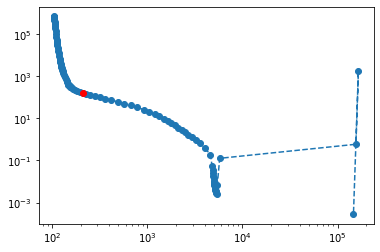

In [15]:
idx = 50
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

(0.0001, 1000.0)

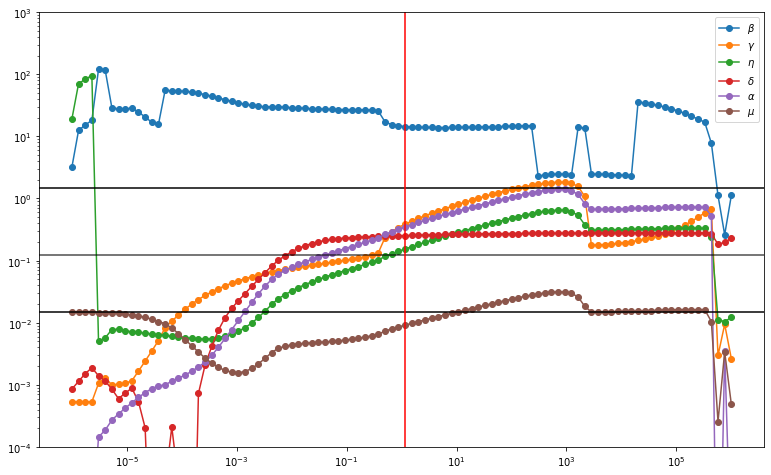

In [16]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

28.1771


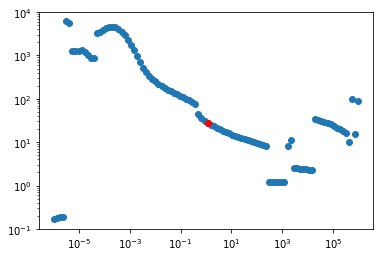

In [17]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

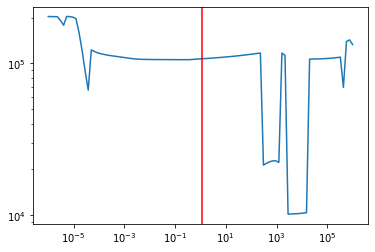

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(14.3951), DM(0.385847), DM(0.153622), DM(0.253393), DM(0.34813), DM(0.00912634))


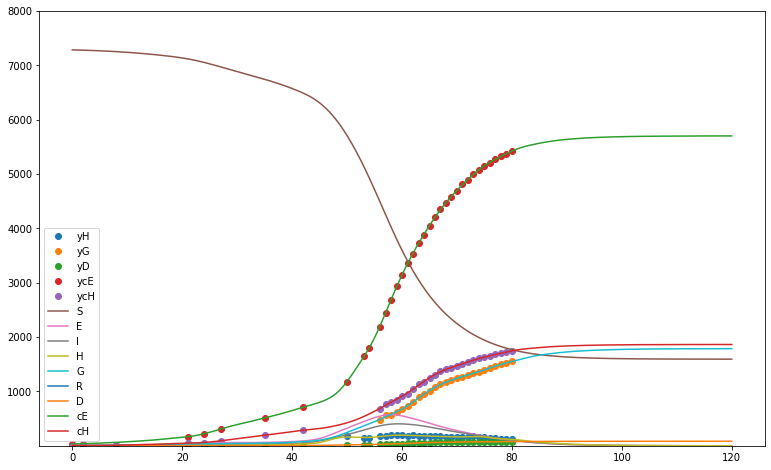

In [19]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [20]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(14.3951)), ('g', DM(0.385847)), ('e', DM(0.153622)), ('d', DM(0.253393)), ('a', DM(0.34813)), ('m', DM(0.00912634))]


[('s', DM(2748.04)),
 ('e', DM(412.769)),
 ('i', DM(343.955)),
 ('h', DM(178.413)),
 ('g', DM(1022.87)),
 ('r', DM(98628.9)),
 ('d', DM(59.2978)),
 ('E', DM(4068.17)),
 ('H', DM(1257.82))]

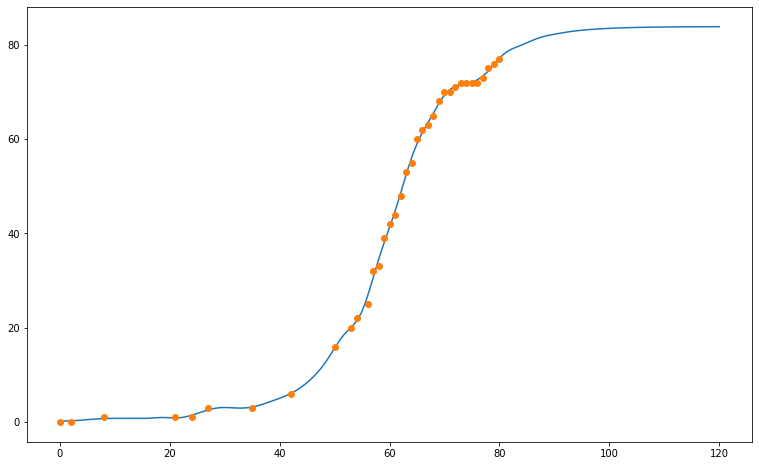

In [21]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')

(0, 6000)

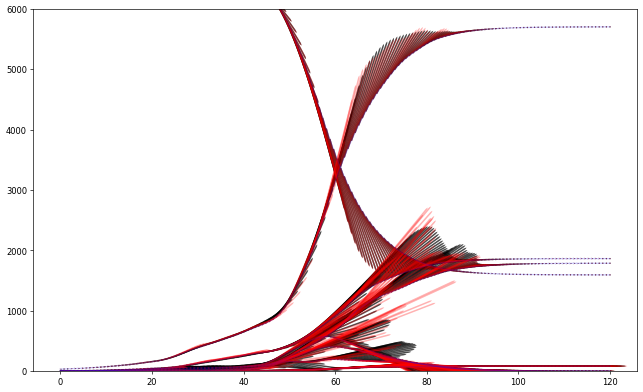

In [22]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

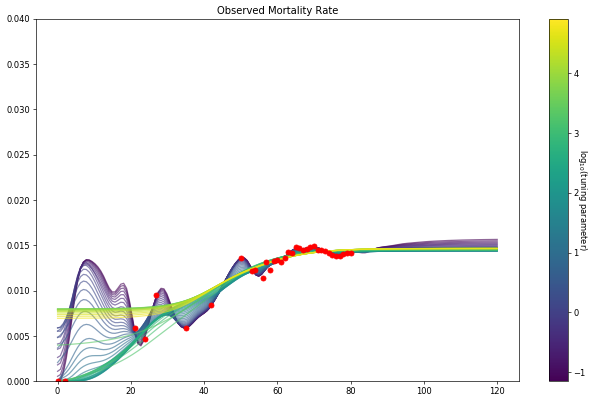

In [23]:

import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.04)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

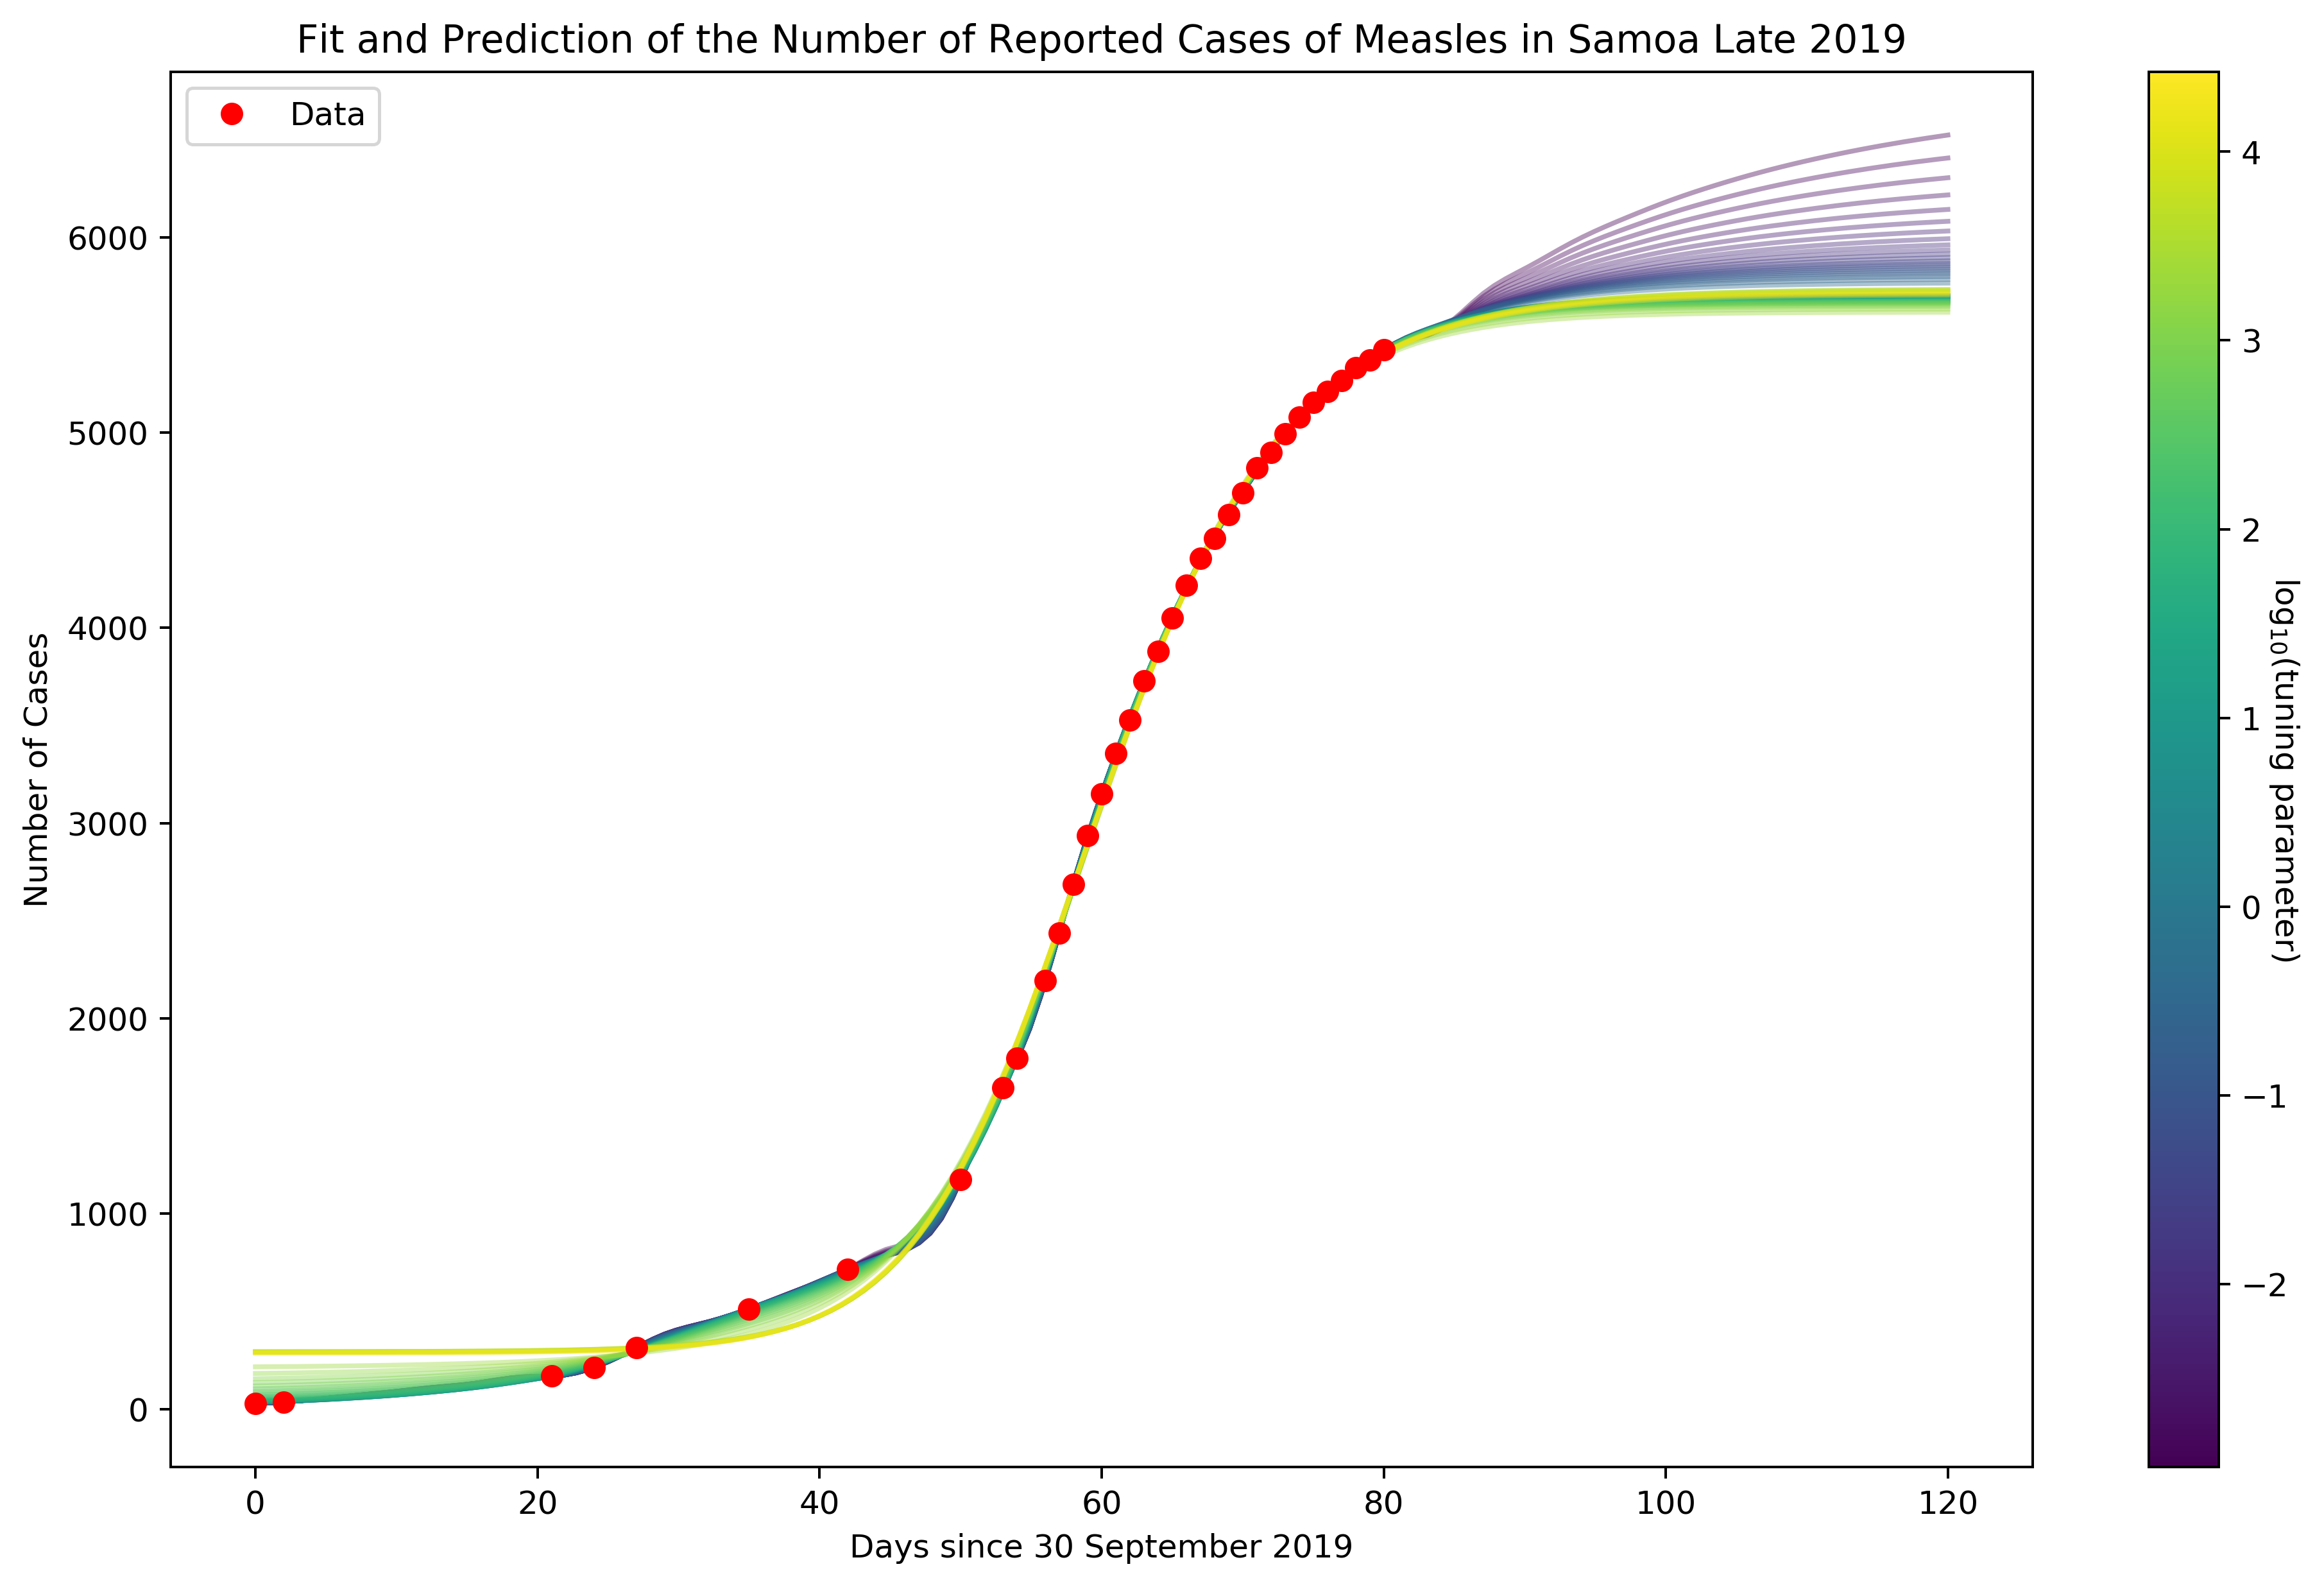

In [24]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

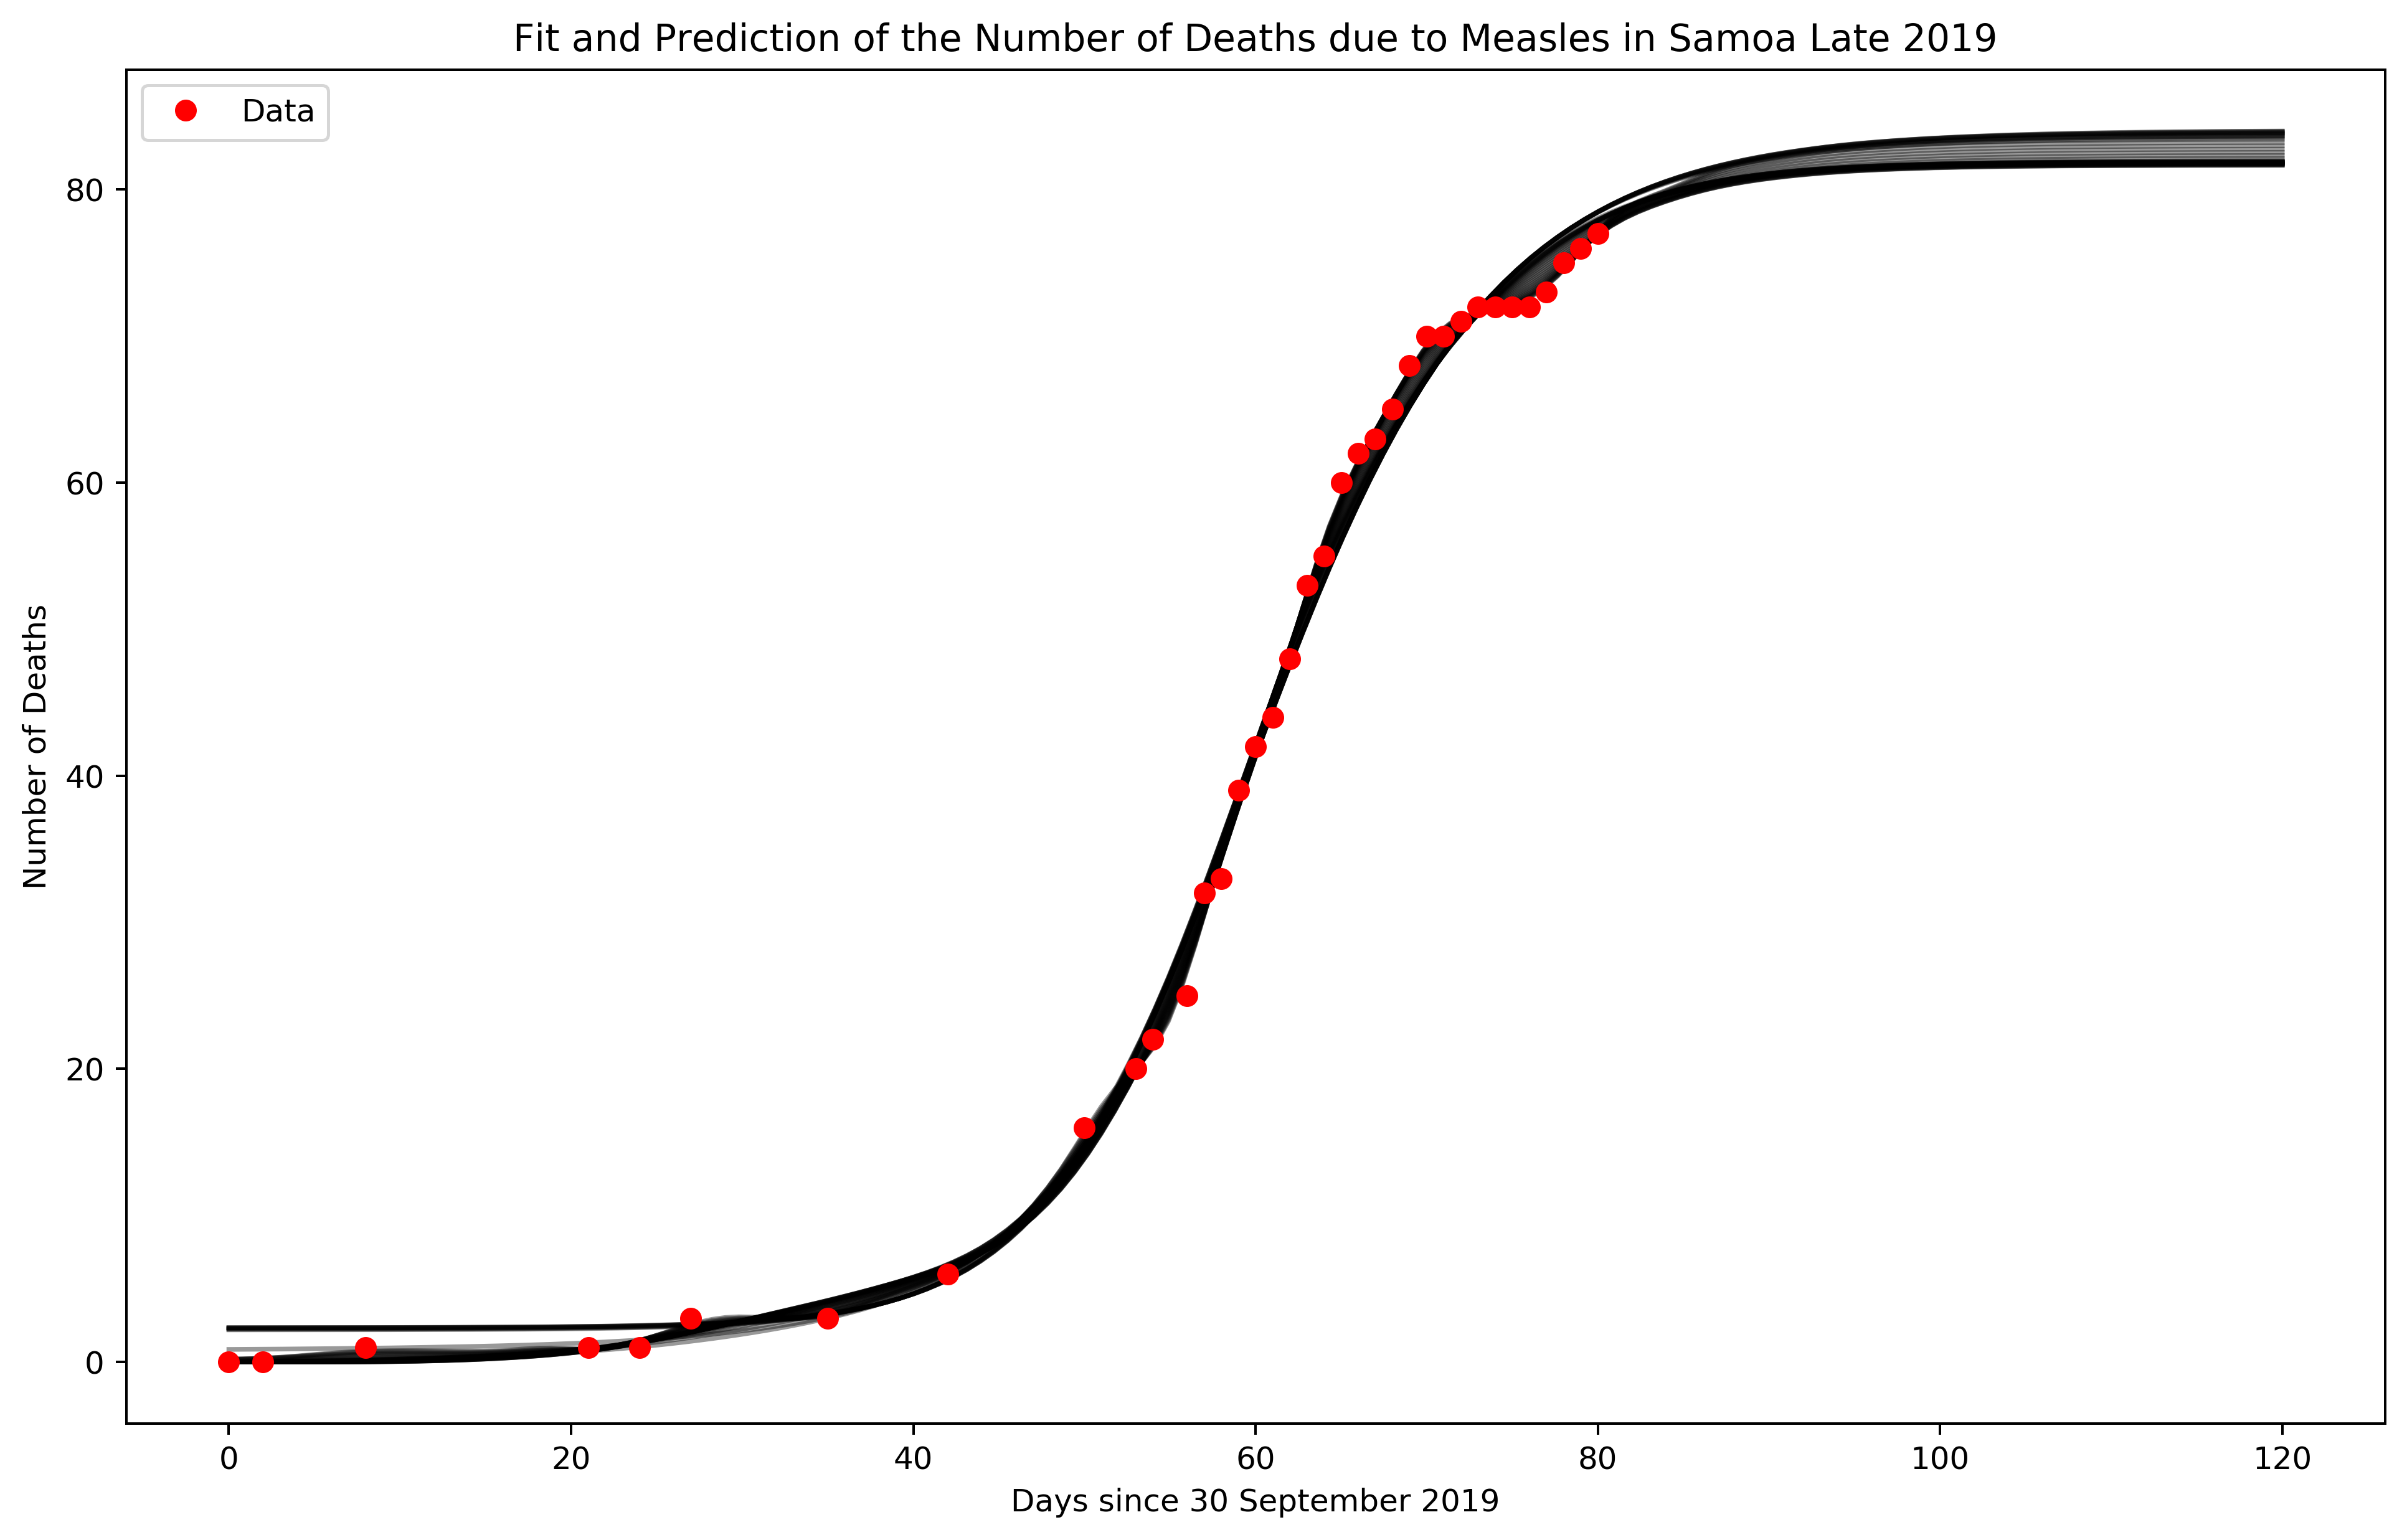

In [25]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (50, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

array([5749.8253466, 5749.8253466])

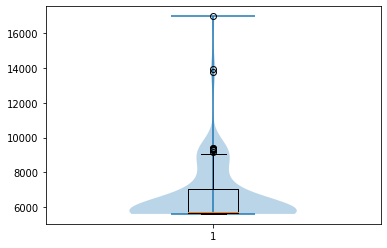

In [26]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [27]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5616.601547412425

In [28]:
np.unique(bx['boxes'][0].get_ydata())

array([5682.9878803 , 7063.19720708])

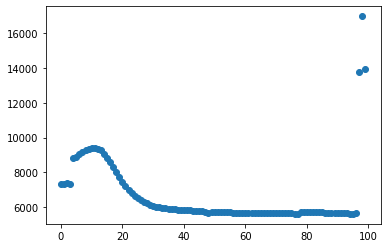

In [29]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

(0, 100)

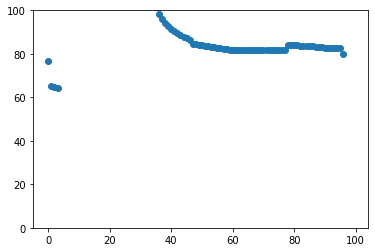

In [30]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

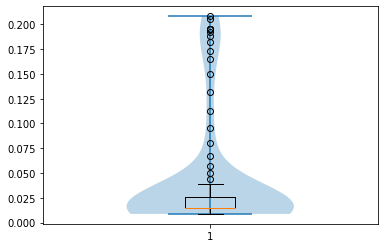

In [31]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [32]:
np.unique(bx['boxes'][0].get_ydata())

array([0.01448632, 0.02597791])

In [33]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

64.45843383624882
83.98468855547877


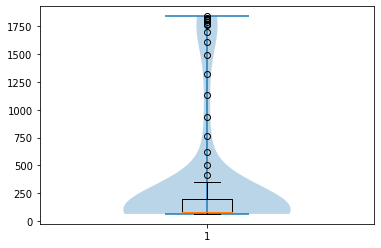

In [34]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([ 82.27774878, 202.60026306])

In [36]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

5462.630163274523
78.22995453522776
